# Dual-fuel Heat Pumps Low-carbon Analysis
By: Erik Janssen
Date: 01/08/2021

## 1 Introduction 
This notebook provides supporting data and analysis for the Sustainable Technologies Evaluation Program (STEP) document titled "Dual Fuel Heat Pump Systems for Home Heating: Analysis of Control Approaches, Utility Costs, and Carbon Emission Reductions." This notebook is not intended to be a complete report in itself, but rather a companion to the previously mentioned document. The analysis was performed in Python, and uses a Jupyter notebook. If these are unfamiliar to the reader, then comments and text is provided throughout and it is possible to look at the actual results (data tables and visualizations) without a solid understanding of the code used in the analysis. For those fluent in Python, the code can be used to do additional analysis beyond what is completed in this notebook.

## 2 Import Libraries

In [1]:
# These are the different Python libraries that will be needed
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np
import datetime
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator

# Want to see full dataframes rather then truncated ones
pd.set_option('display.max_columns', None)

## 3 Parameter assumptions
The analysis requires assumptions for several parameters. 

### 3.1 Natural Gas Rate
The marginal cost of natural gas was estimated using the Ontatio Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in an Enbridge service area, one for 100 m$^{3}$ consumption and one for 200 m$^{3}$. These are shown below. 
![GasBills2.png](GasBills2.png)


The difference in cost between the two bills is $\$$ 36.4 - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.364 $\$/m^{3}$. The energy density of natural gas varies. On previous projects, we have been advised by Enbridge to assume 10.5 kWh/m$^{3}$. Note that in this analysis kWh will be used as a unit for both heat energy and electrical energy. Using the energy density, it is possible to express the gas cost in terms of energy rather than volume. It is 0.0317 $\$$/kWh.

At the end of 2020 the federal government announced a new cabron pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This has significant implications for dual fuel heat pump systems. This is outlined in the dataframe below. It ignores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [2]:
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Estimated Rate ($/m3)
0,2021,40,0.078300,0.364000
1,2022,50,0.097875,0.383575
2,2023,65,0.127238,0.412938
3,2024,80,0.156600,0.442300
4,2025,95,0.185963,0.471662
5,2026,110,0.215325,0.501025
6,2027,125,0.244688,0.530388
7,2028,140,0.274050,0.559750
8,2029,155,0.303412,0.589113
9,2030,170,0.332775,0.618475


This analysis will use the 2025 natural gas rate for the brunt of the calculations. It will also consider the 2030 rate near the end.

In [3]:
# Define the gas cost parameters
gas_cost_m3 = 0.472 # in units $/m3
gas_cost_kWh = 0.472/10.5 # in units $/kWh

### 3.2 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Six bills were calculated in total. Each bill assumed that electricity was consumed entirely in only one time-of-use (TOU) bracket. For TOU bracket a 500 kWh and a 600 kWh was calculated. The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in April 2021.

The results for peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is $\$$ 18.54, leading to marginal peak electricity cost estimate of 0.185 $\$$/kWh.
![peak_elec_bills.png](peak_elec_bills.png)

The results for mid-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is  $\$$ 13.16, leading to marginal peak electricity cost estimate of 0.136  $\$$ /kWh.
![mid_peak_elec_bills.png](mid_peak_elec_bills.png)

The results for off-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 9.95 $\$$, leading to marginal peak electricity cost estimate of  0.0995 $\$$/kWh.
![off_peak_elec_bills.png](off_peak_elec_bills.png)

In the previous section, the natural gas rate for 2025 was selected for analysis because gas rates are increasing due to carbon pricing. To adjust the peak, mid-peak, and off-peak electricity rates to 2025 values a 2% per year increase was assumed. 

In [4]:
# Define electricity cost parameters
elec_cost_off = 0.0995 * (1.02) ** 4 #in units $/kWh
elec_cost_mid = 0.136 * (1.02) ** 4 #in units $/kWh
elec_cost_peak = 0.185 * (1.02) ** 4 #in units $/kWh

In [5]:
print("The assumed peak electricity rate for 2025 is " + str(round(elec_cost_peak,3)) + " $/kWh.")
print("The assumed mid-peak electricity rate for 2025 is " + str(round(elec_cost_mid,3)) + " $/kWh.")
print("The assumed off-peak electricity rate for 2025 is " + str(round(elec_cost_off,3)) + " $/kWh.")

The assumed peak electricity rate for 2025 is 0.2 $/kWh.
The assumed mid-peak electricity rate for 2025 is 0.147 $/kWh.
The assumed off-peak electricity rate for 2025 is 0.108 $/kWh.


### 3.3 Emission Factors
The emission factor for electricity used in the analysis is the most recent marginal value for winter (from 2018) from TAF (https://taf.ca/wp-content/uploads/2019/06/A-Clearer-View-on-Ontarios-Emissions-June-2019.pdf, pg. 15) - 0.119 kg CO$_{2}$e per kWh. The emission factor for the combustion of natural gas was taken from Canada's National Inventory Report. It is 1.89 kg CO$_{2}$ per m$^{3}$. Expressed in units of energy rather than volume it is 0.180 kg CO$_{2}$e per kWh. 


In [6]:
# Define emission factor assumptions
EF_elec = 0.119 # in units kg CO2e per kWh
EF_gas_vol = 1.89 # in units kg CO2e per m3
EF_gas_kWh = 0.180 # in units kg CO2e per kWh

### 3.4 Equipment Costs
Equipment costs for a conventional high-efficiency furnace, and also for a dual-fuel system, were estimated using invoices from actual standard installs that were shared with STEP. Without comprehensive market analysis on product pricing, real invoices are a good source of cost data. An invoice for a conventional high efficiency furnace and A/C is shown below. The furnace has an 95% AFUE and 60 kBtu/hr heating capacity. The A/C unit has 1.5 tons cooling capacity. 
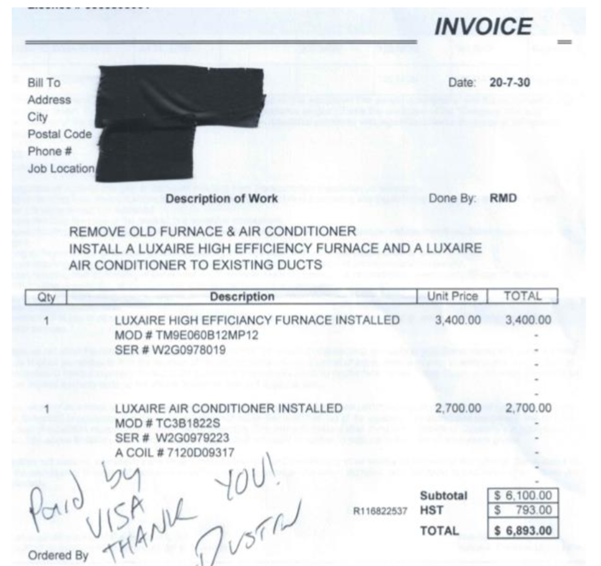
A sample equipment schedule and invioce from a dual fuel system is shown below.The furnace is a 97% variable capacity furnace with modulating gas valve and 60 kBtu/hr heating capacity. The heat pump is a 2-stage unit with 2 tons nominal capacity.
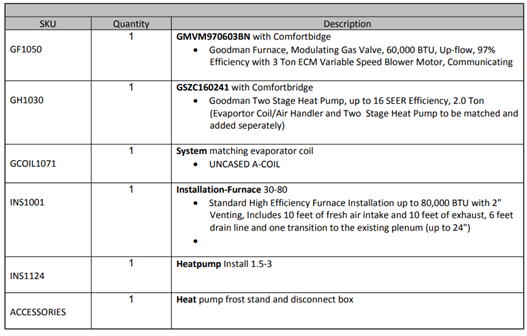
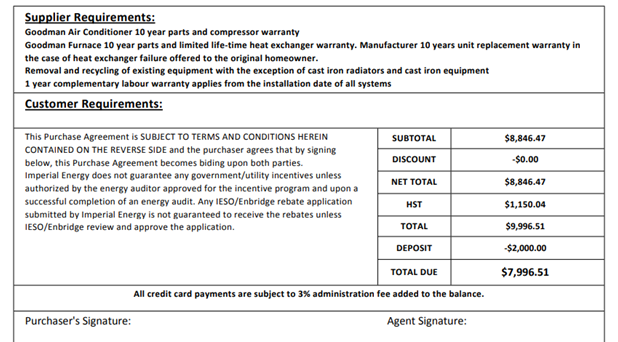
Note that the dual-fuel system has a more advanced furnace and a larger cooling capacity. The incremental capital cost for the dual fuel system is approximately $3,000.



In [7]:
# Define system costs
furnace_cost = 6893
dualfuel_cost = 9996
print("The incremental capital cost for the dual fuel system is:" + " $" + str(dualfuel_cost-furnace_cost))

The incremental capital cost for the dual fuel system is: $3103


### 3.5 Performance 
This analysis simply uses the manufacturer provided values. The base case furnace efficiency assumption is 95%, which is the AFUE value. The heat pump efficiency (COP) is temperature-dependent. Screenshots of the performance data from the manufacturer of the equipment on the above invoice is provided below. The data is provided for each heat pump stage (since it is two-stage). Data is provided for the 2-ton unit (from the invoice) below.  
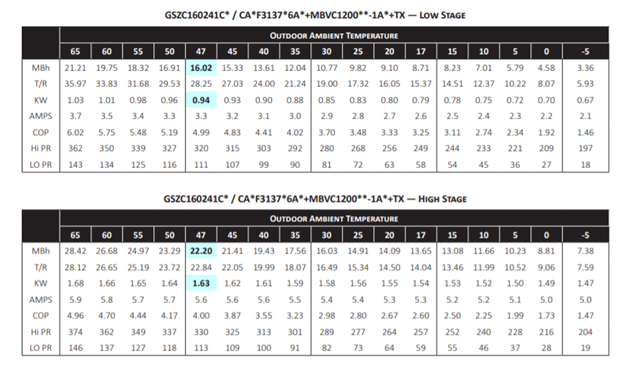
Data is also provided below for a 3-ton unit. As will be seen, carbon savings potential for the 3-ton unit are greater.
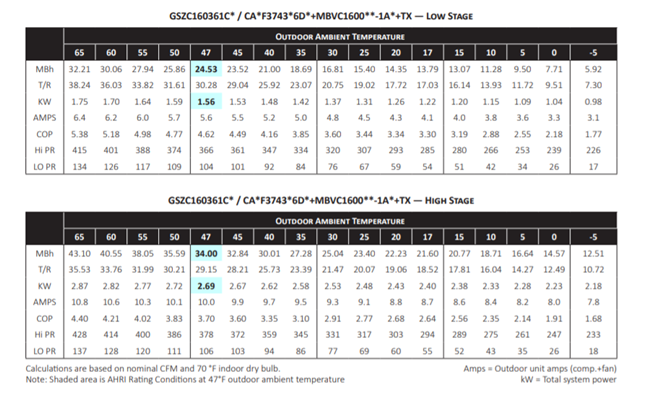
The capacity and COP data has been placed in a separate data file and can be visualized. Data is imported and visualized below.

In [8]:
# Import 2-ton HP data
two_ton_HP = pd.read_csv("HP2tonPerformance.csv") 

# Add column for temperature in Celsius
two_ton_HP['Temp_C'] = [(x-32)*5/9 for x in two_ton_HP.Temp_F]

# Have a look at data 
two_ton_HP.head(20)

,Temp_F,COP_Low_Stage,COP_High_Stage,Cap_Low_Stage_kBtu_hr,Cap_High_Stage_kBtu_hr,Temp_C
0,65,6.02,4.96,21.21,28.42,18.333333
1,60,5.75,4.70,19.75,26.68,15.555556
2,55,5.48,4.44,18.32,24.97,12.777778
3,50,5.19,4.17,16.91,23.29,10.000000
4,47,4.99,4.00,16.02,22.20,8.333333
5,45,4.83,3.87,15.33,21.41,7.222222
6,40,4.41,3.55,13.61,19.43,4.444444
7,35,4.02,3.23,12.04,17.56,1.666667
8,30,3.70,2.98,10.77,16.03,-1.111111
9,25,3.48,2.80,9.82,14.91,-3.888889


In [9]:
# Import 3-ton HP data
three_ton_HP = pd.read_csv("HP3tonPerformance.csv") 

# Add column for temperature in Celsius
three_ton_HP['Temp_C'] = [(x-32)*5/9 for x in two_ton_HP.Temp_F]

# Have a look at data 
three_ton_HP.head(20)

,Temp_F,COP_Low_Stage,COP_High_Stage,Cap_Low_Stage_kBtu_hr,Cap_High_Stage_kBtu_hr,Temp_C
0,65,5.38,4.40,32.21,43.10,18.333333
1,60,5.18,4.21,30.06,40.55,15.555556
2,55,4.98,4.02,27.94,38.05,12.777778
3,50,4.77,3.83,25.86,35.59,10.000000
4,47,4.62,3.70,24.53,34.00,8.333333
5,45,4.49,3.60,23.52,32.84,7.222222
6,40,4.16,3.35,21.00,30.01,4.444444
7,35,3.85,3.10,18.69,27.28,1.666667
8,30,3.60,2.91,16.81,25.04,-1.111111
9,25,3.44,2.77,14.40,23.40,-3.888889


For the analysis the high and low stage capacity and COP data need to be fit to models. This is done below.

In [10]:
# 2-ton low stage
two_ton_low_cap_model = scipy.interpolate.interp1d(two_ton_HP.Temp_C, two_ton_HP.Cap_Low_Stage_kBtu_hr)
two_ton_low_COP_model = scipy.interpolate.interp1d(two_ton_HP.Temp_C, two_ton_HP.COP_Low_Stage)

# 2-ton high stage
two_ton_high_cap_model = scipy.interpolate.interp1d(two_ton_HP.Temp_C, two_ton_HP.Cap_High_Stage_kBtu_hr)
two_ton_high_COP_model = scipy.interpolate.interp1d(two_ton_HP.Temp_C, two_ton_HP.COP_High_Stage)

# 3-ton low stage
three_ton_low_cap_model = scipy.interpolate.interp1d(three_ton_HP.Temp_C, three_ton_HP.Cap_Low_Stage_kBtu_hr)
three_ton_low_COP_model = scipy.interpolate.interp1d(three_ton_HP.Temp_C, three_ton_HP.COP_Low_Stage)

# 3-ton high stage
three_ton_high_cap_model = scipy.interpolate.interp1d(three_ton_HP.Temp_C, three_ton_HP.Cap_High_Stage_kBtu_hr)
three_ton_high_COP_model = scipy.interpolate.interp1d(three_ton_HP.Temp_C, three_ton_HP.COP_High_Stage)

# Put all the models in a single function for simplicity
def HP_model(typ,stage,size,temp):
    '''
    The "typ" variable should be 'Cap' or 'COP' - it is used to tell the function whether efficiency or capacity data is needed
    The "stage" variable should be an interger 2 or 3 - is used to tell the equipment size in tons
    The "temp" variable is where the user defines the temperature at which they want the efficiency/capacity data
    '''
    val = 0
    if typ == 'COP':
        if stage == 'high':
            if size == 3:
                val = three_ton_high_COP_model(temp)                
            elif size == 2:    
                val = two_ton_high_COP_model(temp) 
        elif stage == 'low':            
            if size == 3:
                val = three_ton_low_COP_model(temp)                
            elif size == 2:    
                val = two_ton_low_COP_model(temp) 
    elif typ == 'Cap':
        if stage == 'high':
            if size == 3:
                val = three_ton_high_cap_model(temp)                
            elif size == 2:    
                val = two_ton_high_cap_model(temp) 
        elif stage == 'low':            
            if size == 3:
                val = three_ton_low_cap_model(temp)                
            elif size == 2:    
                val = two_ton_low_cap_model(temp) 
    return float(val)    

# Test the function - What is the estimated COP of a the 2-ton heat pump on low stage at 1 oC?
HP_model(typ='COP',stage='low',size=2,temp=1)

3.9431999999999996

Now it's possible to visualize the data and the fits of the data.

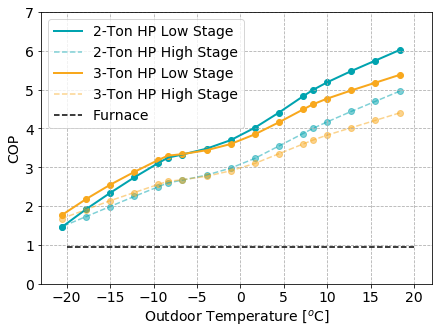

In [11]:
# Going to use these colours throughout for plots that will be used in the white paper document
step_blue = "#00a3af"
step_gold = "#f8a81d"
step_grey = "#808080"

# Define a curve for furnace efficiency
furnace_eff_base = 0.95
furnace_eff_DF = 0.97
Temp = [-20,0,20] # temperature in Celsius
Furnace_curve = [furnace_eff_base,furnace_eff_base,furnace_eff_base] # i.e. it isn't temperature-dependent

# Visualize COPs

plt.figure(figsize=(7,5))

plt.scatter(two_ton_HP.Temp_C,two_ton_HP.COP_Low_Stage, color = step_blue, alpha = 1)
plt.plot(two_ton_HP.Temp_C,[HP_model(typ='COP',stage='low',size=2,temp=x) for x in two_ton_HP.Temp_C], label = '2-Ton HP Low Stage', color = step_blue, alpha = 1, lw=2)

plt.scatter(two_ton_HP.Temp_C,two_ton_HP.COP_High_Stage, color = step_blue, alpha = 0.5)
plt.plot(two_ton_HP.Temp_C,[HP_model(typ='COP',stage='high',size=2,temp=x) for x in two_ton_HP.Temp_C], label = '2-Ton HP High Stage', color = step_blue, alpha = 0.5, ls='--')

plt.scatter(three_ton_HP.Temp_C,three_ton_HP.COP_Low_Stage, color = step_gold, alpha = 1)
plt.plot(three_ton_HP.Temp_C,[HP_model(typ='COP',stage='low',size=3,temp=x) for x in three_ton_HP.Temp_C], label = '3-Ton HP Low Stage', color = step_gold, alpha = 1,lw=2)

plt.scatter(three_ton_HP.Temp_C,three_ton_HP.COP_High_Stage, color = step_gold, alpha = 0.5)
plt.plot(three_ton_HP.Temp_C,[HP_model(typ='COP',stage='high',size=3,temp=x) for x in three_ton_HP.Temp_C], label = '3-Ton HP High Stage', color = step_gold, alpha = 0.5, ls='--')

plt.plot(Temp,Furnace_curve,color='black',label = 'Furnace',ls='--')

plt.legend(fontsize=14)
plt.ylim(0,7)
plt.grid(ls='--')
plt.xlabel("Outdoor Temperature [$^{o}$C]",fontsize=14)
plt.ylabel("COP",fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('COP_curve.png',dpi=1000)

Text(0.5, 1.0, 'Heat Pump and Furnace Capacity')

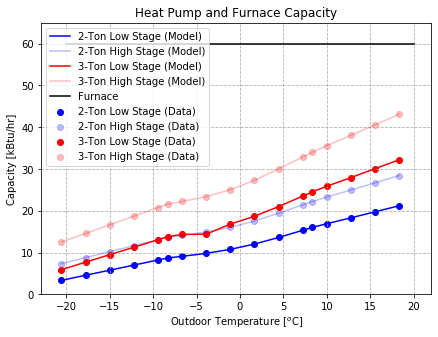

In [12]:
# Define curve for furnace capacity
furnace_cap = 60 # in units kBtu/hr
furnace_cap_curve = [furnace_cap,furnace_cap,furnace_cap] # i.e. it is not temperature-dependent

# Visualize Capacities - doesn't need to look nice yet, not going to add this one in document
plt.figure(figsize=(7,5))
plt.scatter(two_ton_HP.Temp_C,two_ton_HP.Cap_Low_Stage_kBtu_hr, label = '2-Ton Low Stage (Data)', color = 'blue', alpha = 1)
plt.plot(two_ton_HP.Temp_C,[HP_model(typ='Cap',stage='low',size=2,temp=x) for x in two_ton_HP.Temp_C], label = '2-Ton Low Stage (Model)', color = 'blue', alpha = 1)

plt.scatter(two_ton_HP.Temp_C,two_ton_HP.Cap_High_Stage_kBtu_hr, label = '2-Ton High Stage (Data)', color = 'blue', alpha = 0.25)
plt.plot(two_ton_HP.Temp_C,[HP_model(typ='Cap',stage='high',size=2,temp=x) for x in two_ton_HP.Temp_C], label = '2-Ton High Stage (Model)', color = 'blue', alpha = 0.25)

plt.scatter(three_ton_HP.Temp_C,three_ton_HP.Cap_Low_Stage_kBtu_hr, label = '3-Ton Low Stage (Data)', color = 'red', alpha = 1)
plt.plot(three_ton_HP.Temp_C,[HP_model(typ='Cap',stage='low',size=3,temp=x) for x in three_ton_HP.Temp_C], label = '3-Ton Low Stage (Model)', color = 'red', alpha = 1)

plt.scatter(three_ton_HP.Temp_C,three_ton_HP.Cap_High_Stage_kBtu_hr, label = '3-Ton High Stage (Data)', color = 'red', alpha = 0.25)
plt.plot(three_ton_HP.Temp_C,[HP_model(typ='Cap',stage='high',size=3,temp=x) for x in three_ton_HP.Temp_C], label = '3-Ton High Stage (Model)', color = 'red', alpha = 0.25)

plt.plot(Temp,furnace_cap_curve,color='black',label = 'Furnace')

plt.legend()
plt.ylim(0,65)
plt.grid(ls='--')
plt.xlabel("Outdoor Temperature [$^{o}$C]")
plt.ylabel("Capacity [kBtu/hr]")
plt.title("Heat Pump and Furnace Capacity")

### 3.6 Building Load 
The analysis assumed the building load was linear and was such that the furnace (60 kBtu/hr) could fully handle the heating load of the home at an outdoor temperature of -30 $^{o}$C (plus an additional "fudge factor") and also that heating was no longer required above 18 $^{o}$C. 

In [13]:
# Slope of the building load curve
m = (50-0)/(-30-18)

# Intercept of the building load curve
b = 0 - m*18

# Define function
def building_load(T):
    load = m * T + b
    return load

#Try it out
print('The building heating load is ' + str(building_load(-15)) + ' at -15 C.')

The building heating load is 34.375 at -15 C.


It's helpful to plot the building load curve alongside the capacity curves. It shows when a heat pump can meet the building load, and when the furnace would be required. This is plotted below.

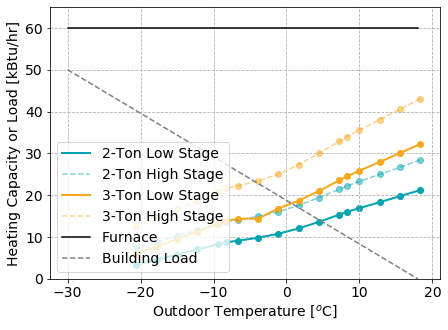

In [14]:
# Create a load curve
Temp = [-30,0,18]
load_temps = [-30,0,18]
load_curve = [building_load(x) for x in load_temps]

# Create a plot 
plt.figure(figsize=(7,5))
plt.plot(two_ton_HP.Temp_C,two_ton_HP.Cap_Low_Stage_kBtu_hr, label = '2-Ton Low Stage', color = step_blue, alpha = 1,lw=2)
plt.scatter(two_ton_HP.Temp_C,two_ton_HP.Cap_Low_Stage_kBtu_hr, color = step_blue, alpha = 1)

plt.plot(two_ton_HP.Temp_C,two_ton_HP.Cap_High_Stage_kBtu_hr, label = '2-Ton High Stage', color = step_blue, alpha = 0.5, ls='--')
plt.scatter(two_ton_HP.Temp_C,two_ton_HP.Cap_High_Stage_kBtu_hr, color = step_blue, alpha = 0.5)

plt.plot(three_ton_HP.Temp_C,three_ton_HP.Cap_Low_Stage_kBtu_hr, label = '3-Ton Low Stage', color = step_gold, alpha = 1,lw=2)
plt.scatter(three_ton_HP.Temp_C,three_ton_HP.Cap_Low_Stage_kBtu_hr, color = step_gold, alpha = 1)

plt.plot(three_ton_HP.Temp_C,three_ton_HP.Cap_High_Stage_kBtu_hr, label = '3-Ton High Stage', color = step_gold, alpha = 0.5,ls='--')
plt.scatter(three_ton_HP.Temp_C,three_ton_HP.Cap_High_Stage_kBtu_hr, color = step_gold, alpha = 0.5)

plt.plot(Temp,furnace_cap_curve,color='black',label = 'Furnace')
plt.plot(load_temps,load_curve,label = 'Building Load',color='grey',ls='--')

plt.legend(fontsize=14,loc=3)
plt.ylim(0,65)
plt.grid(ls='--')
plt.xlabel("Outdoor Temperature [$^{o}$C]", fontsize=14)
plt.ylabel("Heating Capacity or Load [kBtu/hr]",fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('Cap_curve.png',dpi=1000)

For a heating system to be able to supply enough heat for the building load, the capacity curve needs to be greater than the load curve. Note that the furnace capacity is not temperature-dependent and is sized such that it always has enough capacity. 

For the heat pumps, there is a threshold temperature below which there is not enough capacity to meet the load. For the 3-ton system on the high stage, that occurs at approximately -4 $^{o}$C. Below that temperature the heat pump is unable to provide enough heating. For the 2-ton system, it is approximately 1 $^{o}$C. 

Also, for the sake of efficiency, the low-stages would be used whenever possible. For example, with the 3-ton heat pump, the furnace would be used below -4 $^{o}$C, the high-stage of the heat pump could be used from -4 $^{o}$C to 2 $^{o}$C, and the low-stage from 2 $^{o}$C to 18 $^{o}$C. However, the question of which piece of equipment to use under different conditions is also related to costs and that is discussed later on in this notebook.

### 3.7 Heating Hours 
Lastly, an assumption about the statistical distribution of heating hours is required to calculate carbon savings potential. This analysis used typical meterological year (TMY) data for Toronto from the CWEC database. Data is imported below.

In [15]:
# Import data - hourly datafile for Toronto in a typical meteorological year
# Note that it was given a year '2017' that was not in the original file
Toronto_CWEC = pd.read_csv("CAN_ON_TORONTO-CITY-CENTRE_6158359_CWEC.csv",parse_dates=['Datetime'])
Toronto_CWEC.head(5)

,Datetime,Temp_C
0,2017-01-01 00:30:00,-4.5
1,2017-01-01 01:30:00,-6.6
2,2017-01-01 02:30:00,-8.2
3,2017-01-01 03:30:00,-9.2
4,2017-01-01 04:30:00,-9.9


The data will be organized into 1 $^{o}$C wide temperature bins within the analysis. The bin midpoints are defined below.

In [16]:
#Need to put hours into bins, first define the bin mid-points
bin_midpoints = np.arange(-29.5,18,1)
bin_midpoints

array([-29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5,
       -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5,
       -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,
        -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,
         6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,
        15.5,  16.5,  17.5])

The data will be subdivided further into number of hours in each time-of-use (TOU) bracket for each outdoor temperature. This is important to do since the heat pump consumes electricity. The day of the week is added to the dataframe below.

In [17]:
# Add day of week to DF
week_day_dict = {
    0:'Mon',
    1:'Tue',
    2:'Wed',
    3:'Thu',
    4:'Fri',
    5:'Sat',
    6:'Sun',
}

Toronto_CWEC['Day'] = [week_day_dict[x.weekday()] for x in Toronto_CWEC.Datetime]

# Have a look
Toronto_CWEC.head(100)

,Datetime,Temp_C,Day
0,2017-01-01 00:30:00,-4.5,Sun
1,2017-01-01 01:30:00,-6.6,Sun
2,2017-01-01 02:30:00,-8.2,Sun
3,2017-01-01 03:30:00,-9.2,Sun
4,2017-01-01 04:30:00,-9.9,Sun
5,2017-01-01 05:30:00,-10.5,Sun
6,2017-01-01 06:30:00,-11.1,Sun
7,2017-01-01 07:30:00,-11.6,Sun
8,2017-01-01 08:30:00,-11.6,Sun
9,2017-01-01 09:30:00,-10.9,Sun


The analysis requires a function that takes a datetimestamp and determines which TOU bracket it is in. Off-peak TOU is before 7am, after 7pm, and on weekends. Peak TOU in winter is 7am to 11am, and 5pm to 7pm, on weekdays. Mid-peak TOU is 11am to 5pm.

In [18]:
# Define a function that takes a datetime variable and determines which TOU it is in
def TOU_find(date_time,day_of_week):
    TOU = 'null'
    if (date_time.hour < 7) | (date_time.hour >= 19) | (day_of_week  == 'Sat') | (day_of_week == 'Sun'):
        TOU = 'off'
    elif (date_time.hour >= 11) & (date_time.hour < 17):
        TOU = 'mid'
    else:
        TOU = 'peak'
    return TOU
        
# Add TOU to dataframe
Toronto_CWEC['TOU'] = [TOU_find(x,y) for x,y in zip(Toronto_CWEC.Datetime, Toronto_CWEC.Day)]

# Have a look
Toronto_CWEC.head(100)

,Datetime,Temp_C,Day,TOU
0,2017-01-01 00:30:00,-4.5,Sun,off
1,2017-01-01 01:30:00,-6.6,Sun,off
2,2017-01-01 02:30:00,-8.2,Sun,off
3,2017-01-01 03:30:00,-9.2,Sun,off
4,2017-01-01 04:30:00,-9.9,Sun,off
5,2017-01-01 05:30:00,-10.5,Sun,off
6,2017-01-01 06:30:00,-11.1,Sun,off
7,2017-01-01 07:30:00,-11.6,Sun,off
8,2017-01-01 08:30:00,-11.6,Sun,off
9,2017-01-01 09:30:00,-10.9,Sun,off


It's now possible to calculate the number of heating hours in each TOU bracket for each outdoor temperature. This is done below.

In [19]:
#Calculate how many hours at each temperature broken down according to TOU

#Define some empty lists that will hold the number of hours at each outdoor temperature
tot_hours = []
peak_hours = []
off_hours = []
mid_hours = []

for mid_point in bin_midpoints:
    # Set counters at 0
    tot_hour_count = 0
    peak_hour_count = 0
    off_hour_count = 0
    mid_hour_count = 0
    
    for time, temp, tou in zip(Toronto_CWEC.Datetime,Toronto_CWEC['Temp_C'],Toronto_CWEC.TOU):
        if (temp >= (mid_point - 0.5)) & (temp < mid_point + 0.5):
            tot_hour_count = tot_hour_count + 1
            if tou == 'off':
                off_hour_count = off_hour_count + 1
            if tou == 'mid':
                mid_hour_count = mid_hour_count + 1
            if tou == 'peak':
                peak_hour_count = peak_hour_count + 1
    tot_hours.append(tot_hour_count)
    peak_hours.append(peak_hour_count)
    mid_hours.append(mid_hour_count)
    off_hours.append(off_hour_count)

# Put results in a dictionary
tor_dict = {
    'Temp':bin_midpoints,
    'Hours': tot_hours,
    'Hours_Off': off_hours,
    'Hours_Mid': mid_hours,
    'Hours_Peak': peak_hours
}

# Convert dictionary to a dataframe
tor = pd.DataFrame(tor_dict)

# Have a look
tor.head(50)

,Temp,Hours,Hours_Off,Hours_Mid,Hours_Peak
0,-29.5,0,0,0,0
1,-28.5,0,0,0,0
2,-27.5,0,0,0,0
3,-26.5,0,0,0,0
4,-25.5,0,0,0,0
5,-24.5,0,0,0,0
6,-23.5,0,0,0,0
7,-22.5,0,0,0,0
8,-21.5,0,0,0,0
9,-20.5,2,1,0,1


The data can be visualized.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


Text(0.5, 1.0, 'Annual Outdoor Temperature Distribution in Toronto TMY')

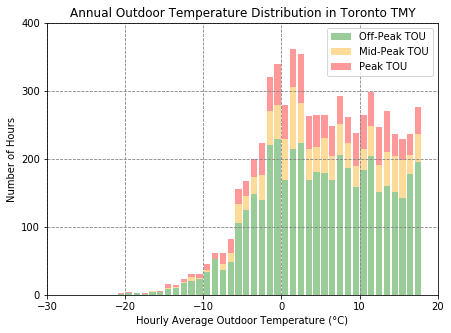

In [20]:
# Visualize data - doesn't need to be pretty, not going to include this plot in white paper
    
#Set transparency
alph = 0.4

#Fig size
plt.figure(figsize=(7, 5))  

#Fig ticks
plt.yticks(range(0, 701, 100), [str(x) for x in range(0, 701, 100)])    

#Spines
ax = plt.subplot(111)    
ax.spines["bottom"].set_visible(True)    
ax.spines["left"].set_visible(True) 

#Add grid
ax.grid(color='grey', linestyle='--')

#PLot series
plt.bar(tor['Temp'], tor['Hours_Off'], alpha = alph, color = 'green',label='Off-Peak TOU')
plt.bar(tor['Temp'], tor['Hours_Mid'], bottom = tor['Hours_Off'], alpha = alph, color = 'orange',label='Mid-Peak TOU')
plt.bar(tor['Temp'], tor['Hours_Peak'], bottom = tor['Hours_Off'] + tor['Hours_Mid'], alpha = alph, color = 'red', label = 'Peak TOU')


#plt.plot(tor['Temp'], tor['Hours'], alpha = alph, color = c1)

#Add labels
plt.xlabel('Hourly Average Outdoor Temperature (\u00B0C)')
plt.ylabel('Number of Hours')
plt.ylim(0,400)
plt.xlim(-30,20)

#Legend
plt.legend()

#Title
plt.title("Annual Outdoor Temperature Distribution in Toronto TMY")


It is possible to multiply the building load (in units of kW) by the hourly average outdoor temperature frequency histogram to calculate a frequency histogram for the heating energy load. The units are then in kWh. Recall that kWh is just a unit of energy. It is commonly used for electrical energy but it can just as well be used to describe heat energy. However, to avoid confusion on the visualization, heating energy is expressed in GJ. In the plot below, the heating energy is the energy loss of the home that must be replaced by a heating system.

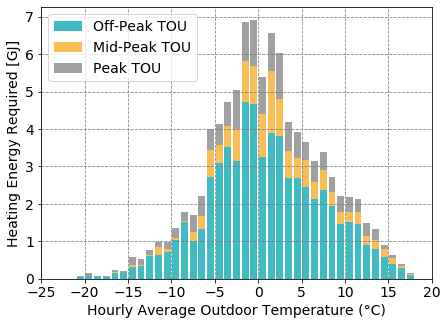

In [21]:
# Create a histogram for energy ENERGY rather than heating HOURS

# Add building load to tor
tor['Building_Load_kW'] = [building_load(x)/3.41 for x in tor.Temp] # 3.41 factor puts it in units kW
tor['Building_Load_kWh'] = tor.Building_Load_kW * tor.Hours
tor['Building_Load_kWh_Off'] = tor.Building_Load_kW * tor.Hours_Off
tor['Building_Load_kWh_Mid'] = tor.Building_Load_kW * tor.Hours_Mid
tor['Building_Load_kWh_Peak'] = tor.Building_Load_kW * tor.Hours_Peak

# Visualize data
c1 = 'red'
    
#Set transparency
alph = 0.75

#Fig size
plt.figure(figsize=(7, 5))  

#Spines
ax = plt.subplot(111)    
ax.spines["bottom"].set_visible(True)    
ax.spines["left"].set_visible(True) 

#Add grid
ax.grid(color='grey', linestyle='--')

#PLot series - express in GJ instead of kWh to avoid confusion 
plt.bar(tor['Temp'], tor['Building_Load_kWh_Off']/278, alpha = alph, color = step_blue, label = 'Off-Peak TOU')
plt.bar(tor['Temp'], tor['Building_Load_kWh_Mid']/278, bottom = tor['Building_Load_kWh_Off']/278, alpha = alph, color = step_gold, label = 'Mid-Peak TOU')
plt.bar(tor['Temp'], tor['Building_Load_kWh_Peak']/278, bottom = tor['Building_Load_kWh_Off']/278 + tor['Building_Load_kWh_Mid']/278, alpha = alph, color = 'grey', label = 'Peak TOU')

#Add labels
plt.xlabel('Hourly Average Outdoor Temperature (\u00B0C)',fontsize=14)
plt.ylabel('Heating Energy Required [GJ]',fontsize=14)
plt.xlim(-25,20)
plt.tick_params(axis='both', labelsize=14)

#Legend
plt.legend(fontsize=14)

#Title
#plt.title("Annual Home Heating Energy Distribution in Toronto TMY")

plt.savefig('TOU_breakdown.png',dpi=1000)

In [22]:
tor.head(50)

,Temp,Hours,Hours_Off,Hours_Mid,Hours_Peak,Building_Load_kW,Building_Load_kWh,Building_Load_kWh_Off,Building_Load_kWh_Mid,Building_Load_kWh_Peak
0,-29.5,0,0,0,0,14.510020,0.000000,0.000000,0.000000,0.000000
1,-28.5,0,0,0,0,14.204545,0.000000,0.000000,0.000000,0.000000
2,-27.5,0,0,0,0,13.899071,0.000000,0.000000,0.000000,0.000000
3,-26.5,0,0,0,0,13.593597,0.000000,0.000000,0.000000,0.000000
4,-25.5,0,0,0,0,13.288123,0.000000,0.000000,0.000000,0.000000
5,-24.5,0,0,0,0,12.982649,0.000000,0.000000,0.000000,0.000000
6,-23.5,0,0,0,0,12.677175,0.000000,0.000000,0.000000,0.000000
7,-22.5,0,0,0,0,12.371701,0.000000,0.000000,0.000000,0.000000
8,-21.5,0,0,0,0,12.066227,0.000000,0.000000,0.000000,0.000000
9,-20.5,2,1,0,1,11.760753,23.521505,11.760753,0.000000,11.760753


Lastly, it's helpful to just get a sense of how much of the heating load is in each TOU.

In [23]:
print(str(int(tor.Building_Load_kWh_Off.sum()/tor.Building_Load_kWh.sum()*100)) + "% of the annual load is during an off-peak TOU.")
print(str(int(tor.Building_Load_kWh_Mid.sum()/tor.Building_Load_kWh.sum()*100)) + "% of the annual load is during an mid-peak TOU.")
print(str(int(tor.Building_Load_kWh_Peak.sum()/tor.Building_Load_kWh.sum()*100)) + "% of the annual load is during a peak TOU.")
print('The annual building heating load is ' + str(int(tor.Building_Load_kWh.sum()/278)) + ' GJ')

66% of the annual load is during an off-peak TOU.
15% of the annual load is during an mid-peak TOU.
17% of the annual load is during a peak TOU.
The annual building heating load is 93 GJ


This concludes the data and parameters section. The analysis sections will evaluate the business case and carbon savings potential of a dual-fuel system.

## 4 Analysis
The analysis considered different scenarios. In each scenario, the annual carbon emissions and utility costs of a dual fuel system was calculated and compared that against a conventional high-efficiency furnace. Cooling costs were neglected because they were assumed to be comparable. This is not strictly true and ought to be considered at a later date. The analysis proceeded by looking at each outdoor temperature bin, determining equipment efficiencies and capacities for that temperature, choosing which piece of equipment would function in which TOU brackets based on given control staregies, and then determining the utility consumption based on the loads and equipment efficiencies. 

The first scenario considered that the unit was controlled for maximum carbon savings. In this scenario the heat pump is operated whenever it has enough capacity to meet the heating load, and the furnace is used when the heat pump does not have enough capacity. This approach does not require smart control. It only requires the equipment to switch from heat pump to furnace at a certain outdoor temperature that is independent of the TOU bracket.

The second scenario considered smart control. It would look at the TOU rate and outdoor temperature and choose which equipment to operate. The third scenario considered different constant switch-over points. A fourth looked at smart control which could balance cost and carbon savings. Additional scenarios were performed as a sensitivity analysis - considering an efficiency derate from the manufacturer provided values. 

## 4.1 Analysis Function
All scenarios were analyzed using the same function, provided below. The purpose of the function is simply to continue populating the dataframe "tor" created above using the temperature bins. The function takes into account whether it is 2-ton or 3-ton heat pump that is being considered. It takes into account the control strategy, whether it will operate to maximize carbon savings or minimize costs. It takes into account performace derates (if desired). For each temperature bin, and each TOU, it then determines which piece of equipment to use and the resulting utility consumption, costs, and emissions. It outputs the results in different formats. The full dataframe can be saved as a ".csv" and analyzed in excel if desired. 

In [129]:
def dual_fuel_analyze(hp_size, # should equal 2 for 2-ton or 3 for 3-ton, other values will cause an error
                      control, # should equal 'max_carbon', 'min_cost', or 'constant_setpoint'
                      switch_point = 'null',  # only need for 'constant_setpoint'
                      print_results = 'null', # 'y' will print results to terminal for easy inspection
                      plots = 'null', # 'y' will print a summary plot
                      save_plot_name ='null', # filename for plot
                      COP_derate = 0, # e.g. to derate COPs by 20% enter 0.20
                      smart_factor = 1, # adjustable factor for smart control - if set to 1 it operates the heat pump
                      # only when it is the cheaper option but if set to 1.1 smart control will operate the heat pump
                      # when it is not more than 10% more expensive than furnace. 
                      # parameters below defined earlier but can also be redefined when calling function
                      furnace_eff_base_func = furnace_eff_base, # base case furnace efficiency (i.e. 0.95)
                      gas_cost_m3_func = gas_cost_m3, # cost per m3 for natural gas
                      furnace_eff_DF_func = furnace_eff_DF, # dual fuel furnace efficiency
                      elec_cost_off_func = elec_cost_off, # off-peak electricity price
                      elec_cost_mid_func = elec_cost_mid, # mid-peak electricity price
                      elec_cost_peak_func = elec_cost_peak, # peak electricity price               
                      EF_elec_func = EF_elec, # electricity emission factor
                      ):
    '''
    This function continues to populate the "tor" dataframe
    It takes various inputs to decide which piece of equipment to operate for which outdoor temp and TOU bracket
    It then provides totals for each parameters (cost, carbon, etc.)
    It outputs plots, a "print statement", as well as detailed and summary dataframes that be used for additional analysis    
    '''  
        
    ############### Initialize Dataframe with Heating Load and Weather Data ###############
    # Define any internal parameters
    gas_energy_dens = 10.5 # kWh per m3    
    gas_cost_kWh_func = gas_cost_m3_func/gas_energy_dens
    
    # Start with temperature distribution
    analysis_df = tor.copy()
    
    ############### Add Columns for Heat Pump Efficiency and Capacity vs. Temperature ##############
    
    # Add column for low stage heating capacities 
    result_list = []
    for x in analysis_df.Temp:
        try:
            result_list.append(HP_model(typ='Cap',stage='low',size=hp_size,temp=x)/3.41)
        except:
            result_list.append(0)
    analysis_df['Low_Stage_Cap_kW'] = result_list

    # Add column for high stage heating capacities 
    result_list = []
    for x in analysis_df.Temp:
        try:
            result_list.append(HP_model(typ='Cap',stage='high',size=hp_size,temp=x)/3.41)
        except:
            result_list.append(0)
    analysis_df['High_Stage_Cap_kW'] = result_list

    # Add column for low stage COPs
    result_list = []
    for x in analysis_df.Temp:
        try:
            result_list.append(HP_model(typ='COP',stage='low',size=hp_size,temp=x)*(1-COP_derate))
        except:
            result_list.append(0)
    analysis_df['Low_Stage_COP'] = result_list

    # Add column for high stage COPs
    result_list = []
    for x in analysis_df.Temp:
        try:
            result_list.append(HP_model(typ='COP',stage='high',size=hp_size,temp=x)*(1-COP_derate))
        except:
            result_list.append(0)
    analysis_df['High_Stage_COP'] = result_list
    
    ################ Determine Which Equipment Has Enough Capacity w.r.t Outdoor Temp ###############
    
    # Define function to compare the required heating capacity against the capacity of the heat pump
    def equipment_choose(load,high_stage_cap,low_stage_cap):
        equip = 'null'
        if load < low_stage_cap: 
            equip = "low_stage" # if the load is less than the low stage heat pump capacity the function returns "low_stage"
        elif (load > low_stage_cap) & (load < high_stage_cap):
            equip = "high_stage" # if load is greater than low stage capacity but less than high stage - return "high_stage""
        elif (load > high_stage_cap):
            equip = 'furnace' # if heat pump doesn't have enough capacity - return "furnace"
        return equip
    
    # Add column that determines if heat pumps have enough capacity - if so, which stage
    analysis_df['Enough_Capacity'] = [equipment_choose(load=x,high_stage_cap=y,low_stage_cap=z) \
                               for x,y,z in zip(analysis_df.Building_Load_kW, \
                               analysis_df.High_Stage_Cap_kW,analysis_df.Low_Stage_Cap_kW)]
    
    ############## Determine Which Equipment Operates Based on the Control Startegy ###############
    
    if control == 'max_carbon':
        # This scenario assumes that the heat pump will operate whenever it has enough capacity. The priority
        # is always to operate on low-stage first if low-stage has enough capacity. It not, it would operate 
        # on high-stage. If high-stage doesn't have enough capacity, then the furnace would operate. This control
        # approach is referred to as "max_carbon." It is equivalent to control based on a simple switch-over temperature
        # except that the switch-over temperature is as low as possible while still meeting the heating load.
        analysis_df['Equipment_Off'] = analysis_df.Enough_Capacity
        analysis_df['Equipment_Mid'] = analysis_df.Enough_Capacity
        analysis_df['Equipment_Peak'] = analysis_df.Enough_Capacity
        
    if control == 'min_cost':
        # Determine which piece of equipment to use for off-peak, mid-peak and peak TOUs - based on lowest cost
        # Essentially it is just a comarison of "cost of fuel (in $/kWh) / efficiency of equipment"

        elec_TOU = {
            'off':elec_cost_off_func,
            'mid':elec_cost_mid_func,
            'peak':elec_cost_peak_func
        }

        def equipment_choose_TOU(enough_cap,TOU,low_COP,high_COP):
            equip = 'null'
            elec_cost = elec_TOU[TOU]    
            if enough_cap == 'furnace': # Furnace is the only piece of equipment with enough capacity
                equip = 'furnace'
            elif enough_cap == 'high_stage': # Heat pump on high stage has enough capacity (but low stage does not)
                if (elec_cost/high_COP) < (smart_factor*(gas_cost_kWh_func/furnace_eff_DF_func)):
                    equip = 'high_stage' # Heat pump on high stage is cheaper than furnace
                else:
                    equip = 'furnace'    # Furnace is cheaper than heat pump on high stage
            elif enough_cap == 'low_stage':
                if (elec_cost/low_COP) < (smart_factor*(gas_cost_kWh_func/furnace_eff_DF_func)):
                    equip = 'low_stage'
                else:
                    equip = 'furnace'
            return equip

        analysis_df['Equipment_Off'] = [equipment_choose_TOU(x,'off',y,z) for x,y,z in zip(analysis_df.Enough_Capacity,analysis_df.Low_Stage_COP,analysis_df.High_Stage_COP)]  # Equipment to use during off-peak TOU
        analysis_df['Equipment_Mid'] = [equipment_choose_TOU(x,'mid',y,z) for x,y,z in zip(analysis_df.Enough_Capacity,analysis_df.Low_Stage_COP,analysis_df.High_Stage_COP)] # Equipment to use during mid-peak TOU
        analysis_df['Equipment_Peak'] = [equipment_choose_TOU(x,'peak',y,z) for x,y,z in zip(analysis_df.Enough_Capacity,analysis_df.Low_Stage_COP,analysis_df.High_Stage_COP)] # Equipment to use during peak TOU

    if control == 'constant_setpoint':
        # The equipment is based on the constant temperature provided in the 'switch_point' variable in the function call.
        # The equipment will be selected as the heat pump above the switch point if the heat pump has enough capacity.
        # If it doesn't have enough capacity, it will be the furnace.
        # Low-stage will be used if possible. If not it will be high-stage. 
        equip_list = []
        for temp,equip in zip(analysis_df.Temp,analysis_df.Enough_Capacity):
            if (temp > switch_point) & (equip != 'furnace'):
                equip_list.append(equip)
            else:
                equip_list.append('furnace')
                
        analysis_df['Equipment_Off'] = equip_list
        analysis_df['Equipment_Mid'] = equip_list
        analysis_df['Equipment_Peak'] = equip_list     
        
    ############### Add Base Case (i.e. Furnace-Only) Results for Consumption, Cost and Emissions ###############
    
    # Add gas consumption for base case (furnace only)
    analysis_df['Furnace_Only_Gas_kWh'] = [x/furnace_eff_base_func for x in analysis_df.Building_Load_kWh]
    
    # Add gas consumption for base case in units of m3
    analysis_df['Furnace_Only_Gas_m3'] = analysis_df.Furnace_Only_Gas_kWh/gas_energy_dens
    
    # Add base case gas cost
    analysis_df['Furnace_Only_Gas_Cost'] = analysis_df.Furnace_Only_Gas_kWh * gas_cost_kWh_func
    
    # Add base case emissions
    analysis_df['Furnace_Only_Gas_kg_CO2'] = analysis_df.Furnace_Only_Gas_kWh * EF_gas_kWh # EF_gas_kWh was defined earlier - it is not something that would change
    
    ############### Add Columns for Duel Fuel Results ###############
    
    # Will need to loop through all TOU brackets for each calculation so need to define some column names here
    equip_cols = ['Equipment_Off','Equipment_Mid','Equipment_Peak']
    building_load_kWh_cols = ['Building_Load_kWh_Off','Building_Load_kWh_Mid','Building_Load_kWh_Peak']
    df_gas_kWh_cols = ['Dual_Fuel_Gas_kWh_Off','Dual_Fuel_Gas_kWh_Mid','Dual_Fuel_Gas_kWh_Peak']
    df_gas_m3_cols = ['Dual_Fuel_Gas_m3_Off','Dual_Fuel_Gas_m3_Mid','Dual_Fuel_Gas_m3_Peak']
    df_gas_cost_cols = ['Dual_Fuel_Gas_Cost_Off','Dual_Fuel_Gas_Cost_Mid','Dual_Fuel_Gas_Cost_Peak']
    df_gas_carb_cols = ['Dual_Fuel_Gas_kg_CO2_Off','Dual_Fuel_Gas_kg_CO2_Mid','Dual_Fuel_Gas_kg_CO2_Peak']
    df_elec_kWh_cols =  ['Dual_Fuel_Elec_kWh_Off','Dual_Fuel_Elec_kWh_Mid','Dual_Fuel_Elec_kWh_Peak']
    df_elec_cost_cols = ['Dual_Fuel_Elec_Cost_Off','Dual_Fuel_Elec_Cost_Mid','Dual_Fuel_Elec_Cost_Peak']
    df_elec_carb_cols = ['Dual_Fuel_Elec_kg_CO2_Off','Dual_Fuel_Elec_kg_CO2_Mid','Dual_Fuel_Elec_kg_CO2_Peak']
    elec_rates = [elec_cost_off_func,elec_cost_mid_func,elec_cost_peak_func]
    
    # Add gas consumption (in kWh) for the dual fuel option
    for equip,load,gas_kWh in zip(equip_cols,building_load_kWh_cols,df_gas_kWh_cols):
        analysis_df[gas_kWh] = [x/furnace_eff_DF_func if y == 'furnace' else 0 for x,y in zip(analysis_df[load],analysis_df[equip])]

    # Add gas consumption (in m3) for the dual fuel option
    for gas_kWh, gas_m3 in zip(df_gas_kWh_cols,df_gas_m3_cols):
        analysis_df[gas_m3] = analysis_df[gas_kWh]/gas_energy_dens
    
    # Add gas consumption cost for the dual fuel option
    for gas_kWh, gas_cost in zip(df_gas_kWh_cols,df_gas_cost_cols):
        analysis_df[gas_cost] = analysis_df[gas_kWh] * gas_cost_kWh_func
    
    # Add gas emssions for the dual fuel option
    for gas_kWh, gas_carb in zip(df_gas_kWh_cols,df_gas_carb_cols):
        analysis_df[gas_carb] = analysis_df[gas_kWh] * EF_gas_kWh
                                                                                            
    # Add elec consumption (in kWh) for the dual fuel option
    for equip, load_col, elec_kWh in zip(equip_cols,building_load_kWh_cols, df_elec_kWh_cols):
        
        result_list = []

        for load,high_COP,equip,low_COP in zip(analysis_df[load_col],
                                               analysis_df.High_Stage_COP,
                                               analysis_df[equip],
                                               analysis_df.Low_Stage_COP):
            if equip == 'furnace':
                result_list.append(0)
            elif equip == 'high_stage':
                result_list.append(load/high_COP)
            elif equip == 'low_stage':
                result_list.append(load/low_COP)

        analysis_df[elec_kWh] = result_list
                                                                                              
    # Add dual fuel elec cost
    for elec_kWh, elec_cost, elec_rate in zip(df_elec_kWh_cols,df_elec_cost_cols, elec_rates):
        analysis_df[elec_cost] = analysis_df[elec_kWh] * elec_rate
                                                                                              
     # Add dual fuel elec  emissions
    for elec_kWh, elec_carb in zip(df_elec_kWh_cols,df_elec_carb_cols):
        analysis_df[elec_carb] = analysis_df[elec_kWh] * EF_elec_func
    
    # Total consumption, cost and carbon for duel options
    analysis_df['Dual_Fuel_Gas_kWh_Tot'] = analysis_df.Dual_Fuel_Gas_kWh_Off + analysis_df.Dual_Fuel_Gas_kWh_Mid + analysis_df.Dual_Fuel_Gas_kWh_Peak
    analysis_df['Dual_Fuel_Gas_m3_Tot'] = analysis_df.Dual_Fuel_Gas_m3_Off + analysis_df.Dual_Fuel_Gas_m3_Mid + analysis_df.Dual_Fuel_Gas_m3_Peak
    analysis_df['Dual_Fuel_Gas_Cost_Tot'] = analysis_df.Dual_Fuel_Gas_Cost_Off + analysis_df.Dual_Fuel_Gas_Cost_Mid + analysis_df.Dual_Fuel_Gas_Cost_Peak
    analysis_df['Dual_Fuel_Gas_kg_CO2_Tot'] = analysis_df.Dual_Fuel_Gas_kg_CO2_Off + analysis_df.Dual_Fuel_Gas_kg_CO2_Mid + analysis_df.Dual_Fuel_Gas_kg_CO2_Peak
    analysis_df['Dual_Fuel_Elec_kWh_Tot'] = analysis_df.Dual_Fuel_Elec_kWh_Off + analysis_df.Dual_Fuel_Elec_kWh_Mid + analysis_df.Dual_Fuel_Elec_kWh_Peak
    analysis_df['Dual_Fuel_Elec_Cost_Tot'] = analysis_df.Dual_Fuel_Elec_Cost_Off + analysis_df.Dual_Fuel_Elec_Cost_Mid + analysis_df.Dual_Fuel_Elec_Cost_Peak
    analysis_df['Dual_Fuel_Elec_kg_CO2_Tot'] = analysis_df.Dual_Fuel_Elec_kg_CO2_Off + analysis_df.Dual_Fuel_Elec_kg_CO2_Mid + analysis_df.Dual_Fuel_Elec_kg_CO2_Peak                                                                                         
    analysis_df['Dual_Fuel_Cost_Tot'] = analysis_df.Dual_Fuel_Elec_Cost_Tot + analysis_df.Dual_Fuel_Gas_Cost_Tot                                                                                           
    analysis_df['Dual_Fuel_kg_CO2_Tot'] = analysis_df.Dual_Fuel_Elec_kg_CO2_Tot + analysis_df.Dual_Fuel_Gas_kg_CO2_Tot                                                                                            
                                                                                              
    ################ Determine the switchover temp above which heat pump is used and below which furnace is used ##################
    switch_over_temps = []
    for equip in equip_cols:
        switch_over_temp = 'null'
        i = 0
        x = 'stay'
        while x == 'stay':
            if analysis_df[equip].to_list()[i] != 'furnace': # Go through equipment column and see when it changes from furnace
                switch_over_temp = str(int(analysis_df.Temp.tolist()[i] - 0.5))
                switch_over_temps.append(switch_over_temp)
                x = 'leave'
            i = i + 1
            if i >= len(analysis_df):
                x = 'leave'
                switch_over_temps.append('Null')
                
    ############ Package Results to Return ###############
    
    # Create dictionary summarizing the results - this will be the same dictionary for each scenario
    # That's why it is also broken down into TOU
    summary_dict = {
        # Include assumptions
        'gas_rate_m3':gas_cost_m3_func,
        'gas_rate_kWh':gas_cost_kWh_func,
        'elec_rate_off':elec_cost_off_func,
        'elec_rate_mid':elec_cost_mid_func,
        'elec_rate_peak':elec_cost_peak_func,
        'gas_EF_per_kWh':EF_gas_kWh,
        'elec_EF':EF_elec_func,
        'base_furnace_eff':furnace_eff_base_func,
        'DF_furnace_eff':furnace_eff_DF_func,
        'COP_derate': COP_derate,
        # Gas base case results
        'tot_base_gas_m3':int(analysis_df.Furnace_Only_Gas_m3.sum()),
        'tot_base_gas_kWh':int(analysis_df.Furnace_Only_Gas_kWh.sum()),
        'tot_base_gas_cost':int(analysis_df.Furnace_Only_Gas_Cost.sum()),
        'tot_base_gas_kg_CO2':int(analysis_df.Furnace_Only_Gas_kg_CO2.sum()),
        # Dual fuel results - gas
        'tot_DF_gas_kWh_off':int(analysis_df.Dual_Fuel_Gas_kWh_Off.sum()),
        'tot_DF_gas_m3_off':int(analysis_df.Dual_Fuel_Gas_m3_Off.sum()),
        'tot_DF_gas_cost_off':int(analysis_df.Dual_Fuel_Gas_Cost_Off.sum()),
        'tot_DF_gas_kgCO2_off':int(analysis_df.Dual_Fuel_Gas_kg_CO2_Off.sum()),
        'tot_DF_gas_kWh_mid':int(analysis_df.Dual_Fuel_Gas_kWh_Mid.sum()),
        'tot_DF_gas_m3_mid':int(analysis_df.Dual_Fuel_Gas_m3_Mid.sum()),
        'tot_DF_gas_cost_mid':int(analysis_df.Dual_Fuel_Elec_Cost_Mid.sum()),
        'tot_DF_gas_kgCO2_mid':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Mid.sum()),
        'tot_DF_gas_kWh_peak':int(analysis_df.Dual_Fuel_Gas_kWh_Peak.sum()),
        'tot_DF_gas_m3_peak':int(analysis_df.Dual_Fuel_Gas_m3_Peak.sum()),
        'tot_DF_gas_cost_peak':int(analysis_df.Dual_Fuel_Gas_Cost_Peak.sum()),
        'tot_DF_gas_kgCO2_peak':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Peak.sum()),
        'tot_DF_gas_kWh':int(analysis_df.Dual_Fuel_Gas_kWh_Tot.sum()),
        'tot_DF_gas_cost':int(analysis_df.Dual_Fuel_Gas_Cost_Tot.sum()),
        'tot_DF_gas_kg_CO2':int(analysis_df.Dual_Fuel_Gas_kg_CO2_Tot.sum()),
        # Dual fuel results - elec        
        'tot_DF_elec_kWh_off':int(analysis_df.Dual_Fuel_Elec_kWh_Off.sum()),
        'tot_DF_elec_cost_off':int(analysis_df.Dual_Fuel_Elec_Cost_Off.sum()),
        'tot_DF_elec_kgCO2_off':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Off.sum()),
        'tot_DF_elec_kWh_mid':int(analysis_df.Dual_Fuel_Elec_kWh_Mid.sum()),
        'tot_DF_elec_cost_mid':int(analysis_df.Dual_Fuel_Elec_Cost_Mid.sum()),
        'tot_DF_elec_kgCO2_mid':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Mid.sum()),
        'tot_DF_elec_kWh_peak':int(analysis_df.Dual_Fuel_Elec_kWh_Peak.sum()),
        'tot_DF_elec_cost_peak':int(analysis_df.Dual_Fuel_Elec_Cost_Peak.sum()),
        'tot_DF_elec_kgCO2_peak':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Peak.sum()),
        'tot_DF_elec_kWh':int(analysis_df.Dual_Fuel_Elec_kWh_Tot.sum()),
        'tot_DF_elec_cost':int(analysis_df.Dual_Fuel_Elec_Cost_Tot.sum()),
        'tot_DF_elec_kg_CO2':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Tot.sum()),
        # Duel fuel results gas and elec
        'total_DF_cost':int(analysis_df.Dual_Fuel_Elec_Cost_Tot.sum()+analysis_df.Dual_Fuel_Gas_Cost_Tot.sum()),
        'total_DF_kg_CO2':int(analysis_df.Dual_Fuel_Elec_kg_CO2_Tot.sum()+analysis_df.Dual_Fuel_Gas_kg_CO2_Tot.sum()),
        # Switch-over temps
        'switch_temp_C_off':switch_over_temps[0],
        'switch_temp_C_mid':switch_over_temps[1],
        'switch_temp_C_peak':switch_over_temps[2],
        }      

    summary_df = pd.DataFrame(summary_dict, index = [0])

    quick_summary_dict = {
        'tot_base_gas_cost':summary_dict['tot_base_gas_cost'],
        'tot_base_gas_kg_CO2':summary_dict['tot_base_gas_kg_CO2'],
        'tot_DF_cost':summary_dict['total_DF_cost'],
        'tot_DF_kg_CO2':summary_dict['total_DF_kg_CO2'],
        'tot_cost_savings':summary_dict['tot_base_gas_cost']-summary_dict['total_DF_cost'],
        'tot_cost_savings_percent':round((summary_dict['tot_base_gas_cost']-summary_dict['total_DF_cost'])/summary_dict['tot_base_gas_cost']*100,0),
        'tot_carb_savings_kg':summary_dict['tot_base_gas_kg_CO2']-summary_dict['total_DF_kg_CO2'],
        'tot_carb_savings_percent':round((summary_dict['tot_base_gas_kg_CO2']-summary_dict['total_DF_kg_CO2'])/summary_dict['tot_base_gas_kg_CO2']*100,0),
        'switch_temp_C_off':switch_over_temps[0],
        'switch_temp_C_mid':switch_over_temps[1],
        'switch_temp_C_peak':switch_over_temps[2],
        }   
        
    quick_summary_df = pd.DataFrame(quick_summary_dict, index = [0])

    return_dict = {
        "detailed_summary":summary_df,
        "full_dataframe":analysis_df,
        "quick_summary":quick_summary_df,
    }
    
    ############### Visualize ###############
    if plots == 'y':

        #Fig size
        plt.figure(figsize=(7, 5))  

        #Spines
        ax = plt.subplot(111)    
        ax.spines["bottom"].set_visible(True)    
        ax.spines["left"].set_visible(True) 

        #Add grid
        ax.grid(color='grey', linestyle='--')
        
        # Going to identify when when pump is operating by adjusting the transparency (alpha) of the bar plots
        # Just need to compare temp bins against the switch-over temperature that was determined previously
        
        #Need function to adjust transparency of a color
        def hex_to_rgb(value):
            value = value.lstrip('#')
            lv = len(value)
            return tuple(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))

        def make_rgb_transparent(rgb, alpha): # Takes color in rgb and alpha value - returns rgb of new color with alpha value
            bg_rgb = [1,1,1] # white
            return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
        
        alpha_off = []
        alpha_mid = []
        alpha_peak = []
        
        alpha_lists = [alpha_off,alpha_mid,alpha_peak]
        colors = [step_blue,step_gold,step_grey]
             
        for alpha_list,switch_temp,color in zip(alpha_lists,switch_over_temps,colors):
            for temp in analysis_df.Temp:
                if switch_temp == 'Null':
                    alpha_list.append(make_rgb_transparent(hex_to_rgb(color),0.2))
                elif temp > int(switch_temp):
                    alpha_list.append(color)
                else:
                    alpha_list.append(make_rgb_transparent(hex_to_rgb(color),0.2))                
                
        #PLot series - express in GJ instead of kWh to avoid confusion 
        plt.bar(analysis_df['Temp'], 
                analysis_df['Building_Load_kWh_Off']/278, 
                color = alpha_lists[0], 
                label = 'Off-Peak TOU')
        plt.bar(analysis_df['Temp'], 
                analysis_df['Building_Load_kWh_Mid']/278, 
                bottom = tor['Building_Load_kWh_Off']/278, 
                color = alpha_lists[1], 
                label = 'Mid-Peak TOU')
        plt.bar(analysis_df['Temp'], 
                analysis_df['Building_Load_kWh_Peak']/278, 
                bottom = tor['Building_Load_kWh_Off']/278 + tor['Building_Load_kWh_Mid']/278, 
                color = alpha_lists[2], 
                label = 'Peak TOU')

        #Add labels
        plt.xlabel('Hourly Average Outdoor Temperature (\u00B0C)',fontsize=14)
        plt.ylabel('Heating Energy Provided [GJ]',fontsize=14)
        plt.xlim(-25,20)
        plt.tick_params(axis='both', labelsize=14)

        #Legend
        legend_elements = [Patch(facecolor=step_blue, label='Off-Peak TOU'),                          
                           Patch(facecolor=step_gold, label='Mid-Peak TOU'),
                           Patch(facecolor=step_grey, label='Peak TOU')]
        plt.legend(handles=legend_elements,fontsize=14)

        #Save       
        plt.savefig(save_plot_name + '.png', dpi=1000)
    
    ############### Display Results ###############
    if print_results == 'y':
        print("Results:")    
        print("The total annual utility cost for just using a furnace is: $ " + str(quick_summary_dict['tot_base_gas_cost']))
        print("The total annual emissions for just using the furnace is: " + str(quick_summary_dict['tot_base_gas_kg_CO2']) + " kg")
        print("The total annual utility costs for the dual fuel system is: $ " + str(quick_summary_dict['tot_DF_cost']))
        print("The total annual emissions for the dual fuel system is: " + str(quick_summary_dict['tot_DF_kg_CO2']) + " kg")
        print("The total annual cost savings is: $ " + str(quick_summary_dict['tot_cost_savings']))
        print("The total annual emissions savings is: " + str(quick_summary_dict['tot_carb_savings_kg']) + " kg")
        print("The relative emissions savings of the dual fuel system versus a furnace is: " + str(quick_summary_dict['tot_carb_savings_percent']) + " %")
        print("The relative costs savings of the dual fuel system versus a furnace is: " + str(quick_summary_dict['tot_cost_savings_percent']) + " %")
        print("The switch over temp for off-peak TOU is: " + str(quick_summary_dict['switch_temp_C_off']) + " oC")
        print("The switch over temp for mid-peak TOU is: " + str(quick_summary_dict['switch_temp_C_mid']) + " oC")
        print("The switch over temp for peak TOU is: " + str(quick_summary_dict['switch_temp_C_peak']) + " oC")
        
    return return_dict
      

## 4.2 Maximum Carbon Savings Results
Use function to analyze results for a dual fuel system with 2-ton heat pump operating to maximize carbon savings.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1027
The total annual emissions for the dual fuel system is: 2879 kg
The total annual cost savings is: $ 206
The total annual emissions savings is: 2061 kg
The relative emissions savings of the dual fuel system versus a furnace is: 42.0 %
The relative costs savings of the dual fuel system versus a furnace is: 17.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 1 oC


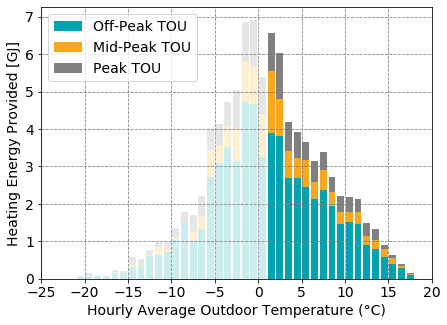

In [25]:
two_ton_max_carbon_0 = dual_fuel_analyze(hp_size=2, control='max_carbon',print_results='y',plots='y',save_plot_name = 'two_ton_max_carbon_0')

In [26]:
# If you want to see the whole dataframe use this code
two_ton_max_carbon_0['full_dataframe'].head(50)

# To then save it use the code below - you can look at the csv in excel if desired
#two_ton_max_carbon_0['full_dataframe'].to_csv('two_ton_max_carbon_0.csv')

# You can also see a detailed summary using the code below
# two_ton_max_carbon_0['detailed_summary'].head()

# Or you can see a quick summary using this code
# two_ton_max_carbon_0['quick_summary'].head()

# I've ommitted these from the notebook because it takes up to much space and we are considering 
# many different scenarios. 

,Temp,Hours,Hours_Off,Hours_Mid,Hours_Peak,Building_Load_kW,Building_Load_kWh,Building_Load_kWh_Off,Building_Load_kWh_Mid,Building_Load_kWh_Peak,Low_Stage_Cap_kW,High_Stage_Cap_kW,Low_Stage_COP,High_Stage_COP,Enough_Capacity,Equipment_Off,Equipment_Mid,Equipment_Peak,Furnace_Only_Gas_kWh,Furnace_Only_Gas_m3,Furnace_Only_Gas_Cost,Furnace_Only_Gas_kg_CO2,Dual_Fuel_Gas_kWh_Off,Dual_Fuel_Gas_kWh_Mid,Dual_Fuel_Gas_kWh_Peak,Dual_Fuel_Gas_m3_Off,Dual_Fuel_Gas_m3_Mid,Dual_Fuel_Gas_m3_Peak,Dual_Fuel_Gas_Cost_Off,Dual_Fuel_Gas_Cost_Mid,Dual_Fuel_Gas_Cost_Peak,Dual_Fuel_Gas_kg_CO2_Off,Dual_Fuel_Gas_kg_CO2_Mid,Dual_Fuel_Gas_kg_CO2_Peak,Dual_Fuel_Elec_kWh_Off,Dual_Fuel_Elec_kWh_Mid,Dual_Fuel_Elec_kWh_Peak,Dual_Fuel_Elec_Cost_Off,Dual_Fuel_Elec_Cost_Mid,Dual_Fuel_Elec_Cost_Peak,Dual_Fuel_Elec_kg_CO2_Off,Dual_Fuel_Elec_kg_CO2_Mid,Dual_Fuel_Elec_kg_CO2_Peak,Dual_Fuel_Gas_kWh_Tot,Dual_Fuel_Gas_m3_Tot,Dual_Fuel_Gas_Cost_Tot,Dual_Fuel_Gas_kg_CO2_Tot,Dual_Fuel_Elec_kWh_Tot,Dual_Fuel_Elec_Cost_Tot,Dual_Fuel_Elec_kg_CO2_Tot,Dual_Fuel_Cost_Tot,Dual_Fuel_kg_CO2_Tot
0,-29.5,0,0,0,0,14.510020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-28.5,0,0,0,0,14.204545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-27.5,0,0,0,0,13.899071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-26.5,0,0,0,0,13.593597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-25.5,0,0,0,0,13.288123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-24.5,0,0,0,0,12.982649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,-23.5,0,0,0,0,12.677175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,furnace,furnace,furnace,furnace,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

2-ton with 10% COP derate.

In [27]:
two_ton_max_carbon_10 = dual_fuel_analyze(hp_size=2, control='max_carbon',print_results='y',plots='n',COP_derate=0.10)

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1071
The total annual emissions for the dual fuel system is: 2920 kg
The total annual cost savings is: $ 162
The total annual emissions savings is: 2020 kg
The relative emissions savings of the dual fuel system versus a furnace is: 41.0 %
The relative costs savings of the dual fuel system versus a furnace is: 13.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 1 oC


2-ton with 20% COP derate.

In [28]:
two_ton_max_carbon_20 = dual_fuel_analyze(hp_size=2, control='max_carbon',print_results='y',plots='n',COP_derate=0.20)

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1127
The total annual emissions for the dual fuel system is: 2970 kg
The total annual cost savings is: $ 106
The total annual emissions savings is: 1970 kg
The relative emissions savings of the dual fuel system versus a furnace is: 40.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 1 oC


2-ton with 30% COP derate.

In [29]:
two_ton_max_carbon_30 = dual_fuel_analyze(hp_size=2, control='max_carbon',print_results='y',plots='n',COP_derate=0.30)

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1198
The total annual emissions for the dual fuel system is: 3035 kg
The total annual cost savings is: $ 35
The total annual emissions savings is: 1905 kg
The relative emissions savings of the dual fuel system versus a furnace is: 39.0 %
The relative costs savings of the dual fuel system versus a furnace is: 3.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 1 oC


Use function to analyze results for a dual fuel system with 3-ton heat pump operating to maximize carbon savings.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 994
The total annual emissions for the dual fuel system is: 1698 kg
The total annual cost savings is: $ 239
The total annual emissions savings is: 3242 kg
The relative emissions savings of the dual fuel system versus a furnace is: 66.0 %
The relative costs savings of the dual fuel system versus a furnace is: 19.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: -4 oC
The switch over temp for peak TOU is: -4 oC



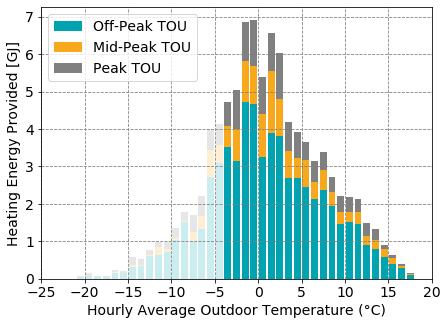

In [30]:
three_ton_max_carbon_0 = dual_fuel_analyze(hp_size=3,control='max_carbon',print_results='y',plots = 'y',save_plot_name='three_ton_max_carbon_0')
print('')

3-ton with 10% COP derate.

In [31]:
three_ton_max_carbon_10 = dual_fuel_analyze(hp_size=3,control='max_carbon',print_results='y',plots = 'n',COP_derate=0.10)
print('')

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1076
The total annual emissions for the dual fuel system is: 1773 kg
The total annual cost savings is: $ 157
The total annual emissions savings is: 3167 kg
The relative emissions savings of the dual fuel system versus a furnace is: 64.0 %
The relative costs savings of the dual fuel system versus a furnace is: 13.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: -4 oC
The switch over temp for peak TOU is: -4 oC



3-ton with 20% COP derate.

In [32]:
three_ton_max_carbon_20 = dual_fuel_analyze(hp_size=3,control='max_carbon',print_results='y',plots = 'n',COP_derate=0.20)
print('')

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1178
The total annual emissions for the dual fuel system is: 1867 kg
The total annual cost savings is: $ 55
The total annual emissions savings is: 3073 kg
The relative emissions savings of the dual fuel system versus a furnace is: 62.0 %
The relative costs savings of the dual fuel system versus a furnace is: 4.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: -4 oC
The switch over temp for peak TOU is: -4 oC



3-ton with 30% COP derate.

In [33]:
three_ton_max_carbon_20 = dual_fuel_analyze(hp_size=3,control='max_carbon',print_results='y',plots = 'n',COP_derate=0.30)
print('')

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1310
The total annual emissions for the dual fuel system is: 1988 kg
The total annual cost savings is: $ -77
The total annual emissions savings is: 2952 kg
The relative emissions savings of the dual fuel system versus a furnace is: 60.0 %
The relative costs savings of the dual fuel system versus a furnace is: -6.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: -4 oC
The switch over temp for peak TOU is: -4 oC



## 4.3 Maximum Cost Savings Results
Use function to analyze results for a dual fuel system with 2-ton heat pump operating to minimize utility costs.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1013
The total annual emissions for the dual fuel system is: 3033 kg
The total annual cost savings is: $ 220
The total annual emissions savings is: 1907 kg
The relative emissions savings of the dual fuel system versus a furnace is: 39.0 %
The relative costs savings of the dual fuel system versus a furnace is: 18.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 5 oC



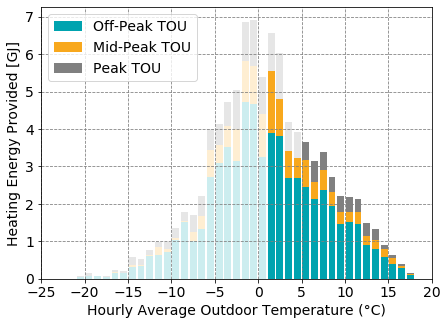

In [34]:
two_ton_lowest_cost_0 = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_0',
                                          COP_derate = 0)
print('')

2-ton with 10% COP derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1047
The total annual emissions for the dual fuel system is: 3251 kg
The total annual cost savings is: $ 186
The total annual emissions savings is: 1689 kg
The relative emissions savings of the dual fuel system versus a furnace is: 34.0 %
The relative costs savings of the dual fuel system versus a furnace is: 15.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 4 oC
The switch over temp for peak TOU is: 7 oC



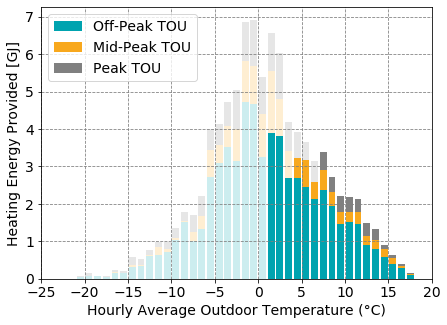

In [35]:
two_ton_lowest_cost_10 = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_10',
                                          COP_derate = 0.10)
print('')

2-ton with 20% COP derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1084
The total annual emissions for the dual fuel system is: 3403 kg
The total annual cost savings is: $ 149
The total annual emissions savings is: 1537 kg
The relative emissions savings of the dual fuel system versus a furnace is: 31.0 %
The relative costs savings of the dual fuel system versus a furnace is: 12.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 5 oC
The switch over temp for peak TOU is: 12 oC



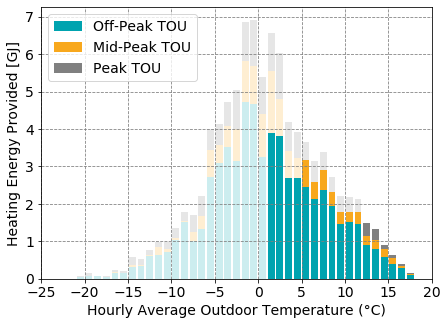

In [36]:
two_ton_lowest_cost_20 = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_20',
                                          COP_derate = 0.20)
print('')

2-ton with 30% derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1127
The total annual emissions for the dual fuel system is: 3633 kg
The total annual cost savings is: $ 106
The total annual emissions savings is: 1307 kg
The relative emissions savings of the dual fuel system versus a furnace is: 26.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 2 oC
The switch over temp for mid-peak TOU is: 5 oC
The switch over temp for peak TOU is: Null oC



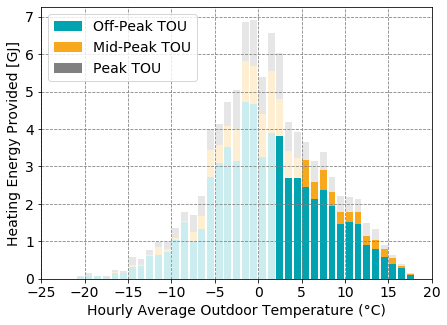

In [37]:
two_ton_lowest_cost_30 = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_30',
                                          COP_derate = 0.30)
print('')

Use function to analyze results for a dual fuel system with 3-ton heat pump operating to minimize utility costs.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 953
The total annual emissions for the dual fuel system is: 2266 kg
The total annual cost savings is: $ 280
The total annual emissions savings is: 2674 kg
The relative emissions savings of the dual fuel system versus a furnace is: 54.0 %
The relative costs savings of the dual fuel system versus a furnace is: 23.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 6 oC



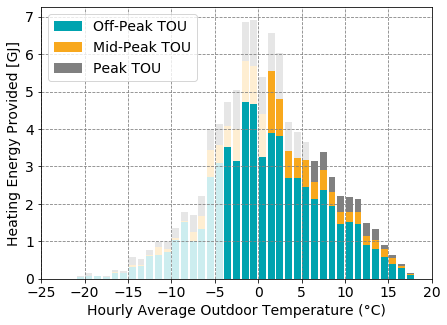

In [38]:
three_ton_lowest_cost_0 = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_0',
                                          COP_derate = 0)
print('')

3-ton with 10% derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1009
The total annual emissions for the dual fuel system is: 2406 kg
The total annual cost savings is: $ 224
The total annual emissions savings is: 2534 kg
The relative emissions savings of the dual fuel system versus a furnace is: 51.0 %
The relative costs savings of the dual fuel system versus a furnace is: 18.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 10 oC



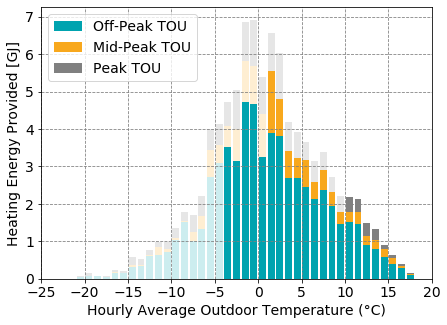

In [39]:
three_ton_lowest_cost_10 = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_10',
                                          COP_derate = 0.10)
print('')

3-ton with 20% derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1073
The total annual emissions for the dual fuel system is: 3081 kg
The total annual cost savings is: $ 160
The total annual emissions savings is: 1859 kg
The relative emissions savings of the dual fuel system versus a furnace is: 38.0 %
The relative costs savings of the dual fuel system versus a furnace is: 13.0 %
The switch over temp for off-peak TOU is: -1 oC
The switch over temp for mid-peak TOU is: 3 oC
The switch over temp for peak TOU is: Null oC



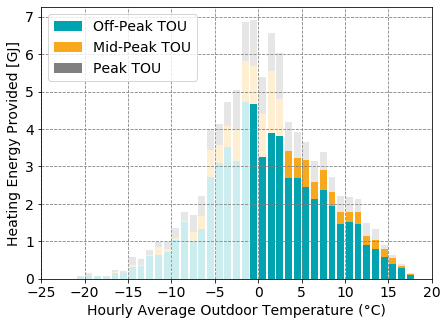

In [40]:
three_ton_lowest_cost_20 = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20',
                                          COP_derate = 0.20)
print('')

3-ton with 30% derate.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1118
The total annual emissions for the dual fuel system is: 3547 kg
The total annual cost savings is: $ 115
The total annual emissions savings is: 1393 kg
The relative emissions savings of the dual fuel system versus a furnace is: 28.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 8 oC
The switch over temp for peak TOU is: Null oC



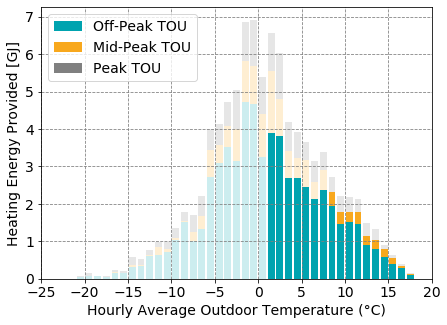

In [41]:
three_ton_lowest_cost_30 = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_30',
                                          COP_derate = 0.30)
print('')

## 4.4 Adjustable Smart Control (i.e. Smart Factor)
The two previous scenario considered, maximum carbon savings and maximum cost savings, are extremes. It is possible to achieve results with a more moderate balance of cost and carbon savings by introducing a new factor into the smart control. The "smart_factor" used in this analysis also allows for the heat pump to operate when it is the more expensive by only a small amount. If set to 1.10 it will choose the heat pump whenever it is not more than 10% greater in cost than the natural gas furnace. This is important because cost-effective carbon savings are still possible when the two heating options (heat pump and furnace) are close in their operation costs. It will reduce cost savings by a small amount but have a comparatively greater impact on carbon emissions (reducing them compared to lowest cost control).

Look at tunable smarter control for 2-ton heat pump first, considering factors from 0 to 30%. Set the COP derate at a constant 30% as this is expected to be the likely scenario as a best estimate (with no other data). Start with 0%.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1127
The total annual emissions for the dual fuel system is: 3633 kg
The total annual cost savings is: $ 106
The total annual emissions savings is: 1307 kg
The relative emissions savings of the dual fuel system versus a furnace is: 26.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 2 oC
The switch over temp for mid-peak TOU is: 5 oC
The switch over temp for peak TOU is: Null oC



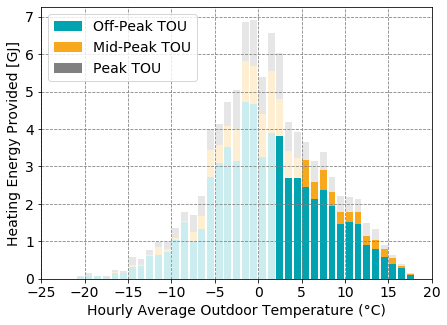

In [162]:
two_ton_lowest_cost_20derate_0factor = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_20derate_0factor',
                                          COP_derate = 0.3,
                                          smart_factor=1)
print('')

2-ton heat pump smart factor at 10%.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1129
The total annual emissions for the dual fuel system is: 3478 kg
The total annual cost savings is: $ 104
The total annual emissions savings is: 1462 kg
The relative emissions savings of the dual fuel system versus a furnace is: 30.0 %
The relative costs savings of the dual fuel system versus a furnace is: 8.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 5 oC
The switch over temp for peak TOU is: 14 oC



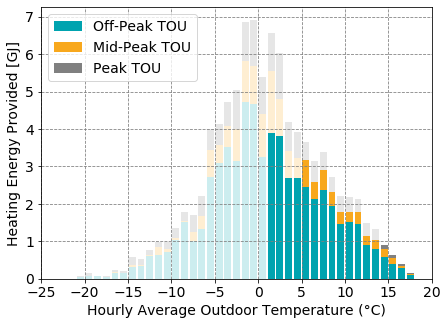

In [163]:
two_ton_lowest_cost_20derate_10factor = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_20derate_10factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.1)
print('')

2-ton heat pump with 20% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1132
The total annual emissions for the dual fuel system is: 3418 kg
The total annual cost savings is: $ 101
The total annual emissions savings is: 1522 kg
The relative emissions savings of the dual fuel system versus a furnace is: 31.0 %
The relative costs savings of the dual fuel system versus a furnace is: 8.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 5 oC
The switch over temp for peak TOU is: 10 oC



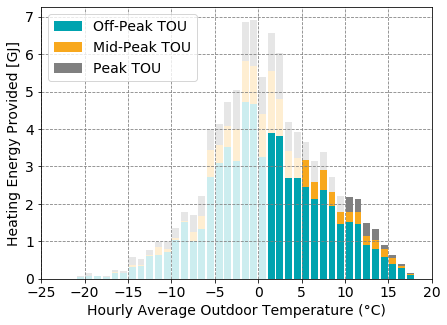

In [164]:
two_ton_lowest_cost_20derate_20factor = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_20derate_20factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.2)
print('')

2-ton heat with 30% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1138
The total annual emissions for the dual fuel system is: 3341 kg
The total annual cost savings is: $ 95
The total annual emissions savings is: 1599 kg
The relative emissions savings of the dual fuel system versus a furnace is: 32.0 %
The relative costs savings of the dual fuel system versus a furnace is: 8.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 4 oC
The switch over temp for peak TOU is: 7 oC



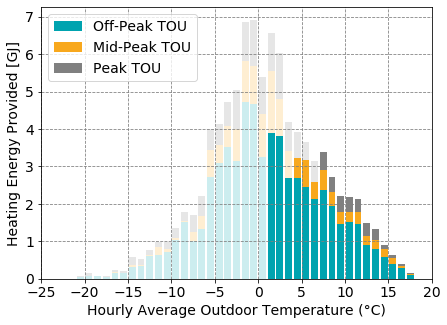

In [165]:
two_ton_lowest_cost_20derate_30factor = dual_fuel_analyze(hp_size=2,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'two_ton_lowest_cost_20derate_30factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.3)
print('')

3-ton with 0% smart_factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1118
The total annual emissions for the dual fuel system is: 3547 kg
The total annual cost savings is: $ 115
The total annual emissions savings is: 1393 kg
The relative emissions savings of the dual fuel system versus a furnace is: 28.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 1 oC
The switch over temp for mid-peak TOU is: 8 oC
The switch over temp for peak TOU is: Null oC



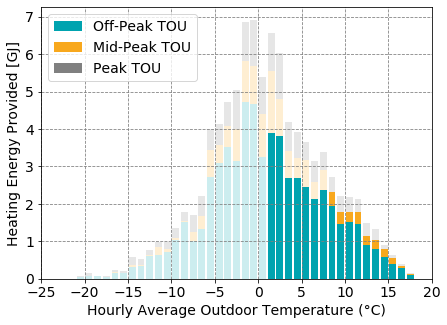

In [166]:
three_ton_lowest_cost_20derate_0factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_0factor',
                                          COP_derate = 0.3,                                                           
                                          smart_factor=1.0)
print('')

3-ton with 10% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1123
The total annual emissions for the dual fuel system is: 3338 kg
The total annual cost savings is: $ 110
The total annual emissions savings is: 1602 kg
The relative emissions savings of the dual fuel system versus a furnace is: 32.0 %
The relative costs savings of the dual fuel system versus a furnace is: 9.0 %
The switch over temp for off-peak TOU is: 0 oC
The switch over temp for mid-peak TOU is: 4 oC
The switch over temp for peak TOU is: Null oC



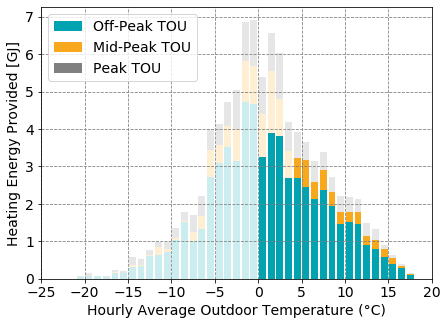

In [167]:
three_ton_lowest_cost_20derate_10factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_10factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.1)
print('')

3-ton with 20% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1162
The total annual emissions for the dual fuel system is: 2634 kg
The total annual cost savings is: $ 71
The total annual emissions savings is: 2306 kg
The relative emissions savings of the dual fuel system versus a furnace is: 47.0 %
The relative costs savings of the dual fuel system versus a furnace is: 6.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 15 oC



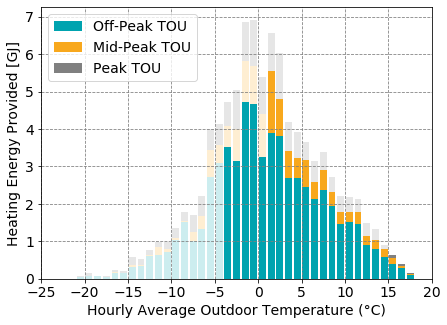

In [168]:
three_ton_lowest_cost_20derate_20factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_20factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.2)
print('')

3-ton with 30% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1167
The total annual emissions for the dual fuel system is: 2570 kg
The total annual cost savings is: $ 66
The total annual emissions savings is: 2370 kg
The relative emissions savings of the dual fuel system versus a furnace is: 48.0 %
The relative costs savings of the dual fuel system versus a furnace is: 5.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 10 oC



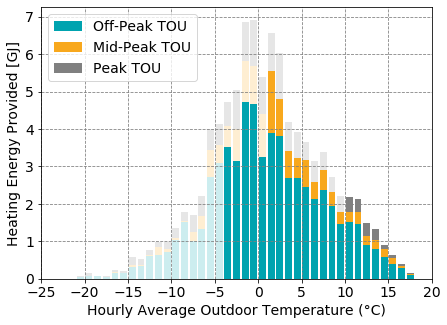

In [169]:
three_ton_lowest_cost_20derate_30factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_30factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.3)
print('')

3-ton with 40% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1173
The total annual emissions for the dual fuel system is: 2516 kg
The total annual cost savings is: $ 60
The total annual emissions savings is: 2424 kg
The relative emissions savings of the dual fuel system versus a furnace is: 49.0 %
The relative costs savings of the dual fuel system versus a furnace is: 5.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 7 oC



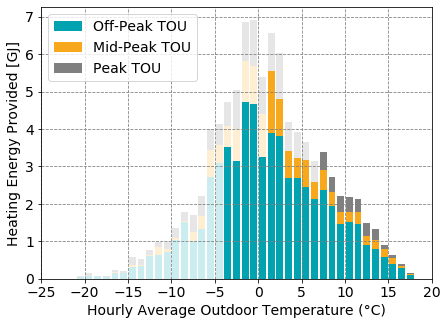

In [170]:
three_ton_lowest_cost_20derate_40factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_40factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.4)
print('')

3-ton with 50% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1183
The total annual emissions for the dual fuel system is: 2447 kg
The total annual cost savings is: $ 50
The total annual emissions savings is: 2493 kg
The relative emissions savings of the dual fuel system versus a furnace is: 50.0 %
The relative costs savings of the dual fuel system versus a furnace is: 4.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: 1 oC
The switch over temp for peak TOU is: 4 oC



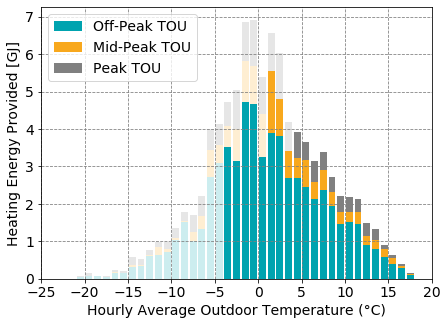

In [171]:
three_ton_lowest_cost_20derate_50factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_50factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.5)
print('')

3-ton with 60% smart factor.

Results:
The total annual utility cost for just using a furnace is: $ 1233
The total annual emissions for just using the furnace is: 4940 kg
The total annual utility costs for the dual fuel system is: $ 1226
The total annual emissions for the dual fuel system is: 2223 kg
The total annual cost savings is: $ 7
The total annual emissions savings is: 2717 kg
The relative emissions savings of the dual fuel system versus a furnace is: 55.0 %
The relative costs savings of the dual fuel system versus a furnace is: 1.0 %
The switch over temp for off-peak TOU is: -4 oC
The switch over temp for mid-peak TOU is: -3 oC
The switch over temp for peak TOU is: 2 oC



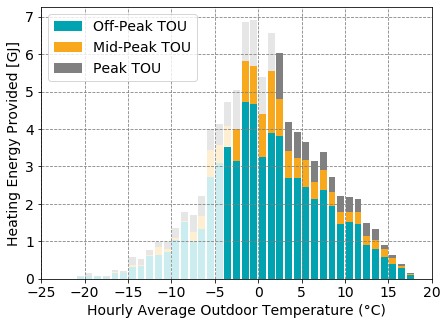

In [172]:
three_ton_lowest_cost_20derate_60factor = dual_fuel_analyze(hp_size=3,
                                          control='min_cost',
                                          print_results='y',
                                          plots='y',
                                          save_plot_name = 'three_ton_lowest_cost_20derate_60factor',
                                          COP_derate = 0.3,
                                          smart_factor=1.6)
print('')

Just look at how things change for 30% derate. Try 30% derate and 40% smart factor.

## 4.5 Constant Temperature Set-point Control and Fuel Cost Escalation
Only going to look at 3-ton heat pump here because it will take us to colder temps. I want to make a plot of constant temperature set-point versus cost and carbon for the different derate scenarios. In that plot I also want to consider both the 2025 rates and the 2030 rates. I will assume electricity continues at 2% escalation (this is based on some analysis of the most recent long-term energy plan) and a natural gas rate for 2030 as in Section 3.1.

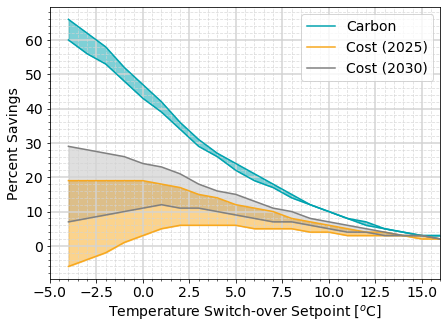

In [161]:
# Define set-points to consider
sps = [-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

# Define some empty lists that will be populate as the function is used to iteratively explores different scenarios
carb_save_list_0 = []
cost_save_list_0 = []
carb_save_list_10 = []
cost_save_list_10 = []
carb_save_list_20 = []
cost_save_list_20 = []
carb_save_list_30 = []
cost_save_list_30 = []

derates = [0,0.1,0.2,0.3]
carb_save_lists = [carb_save_list_0,carb_save_list_10,carb_save_list_20,carb_save_list_30]
cost_save_lists = [cost_save_list_0,cost_save_list_10,cost_save_list_20,cost_save_list_30]

# Determine cost and carbon savings for each set-point
for carb_save_list,cost_save_list,derate in zip(carb_save_lists,cost_save_lists,derates):
    for sp in sps:
        result = dual_fuel_analyze(hp_size=3,control='constant_setpoint',switch_point = sp, print_results='n',COP_derate=derate)
        cost_save = result['quick_summary']['tot_cost_savings_percent'][0]
        carb_save = result['quick_summary']['tot_carb_savings_percent'][0]
        carb_save_list.append(carb_save)
        cost_save_list.append(cost_save)

# Visualize results
# To keep the legend clean I've opted to just fill in between the 0% and 30% derate curves.
# 0% derate has highest savings - 30% has lowest
fig,ax = plt.subplots(figsize=(7,5))
plt.plot(sps,carb_save_list_0,color=step_blue,label = 'Carbon')
plt.plot(sps,cost_save_list_0,color=step_gold,label = 'Cost (2025)')
plt.plot(sps,carb_save_list_30,color=step_blue)
plt.plot(sps,cost_save_list_30,color=step_gold)
plt.fill_between(sps,cost_save_list_0,cost_save_list_30,color = step_gold,alpha=0.5)
plt.fill_between(sps,carb_save_list_0,carb_save_list_30,color = step_blue,alpha=0.5)
plt.xlim(-5,16)

################ Now consider 2030 ###############

# Define new rates for 5-years from now
elec_rate_off_new = elec_cost_off * (1.02)**5 # Add another 5-years of fuel cost escalation
elec_rate_mid_new = elec_cost_mid * (1.02)**5
elec_rate_peak_new = elec_cost_peak * (1.02)**5
gas_rate_new = 0.6184

# Define some empty lists that will be populate as the function is used to iteratively explores different scenarios
carb_save_list_0 = []
cost_save_list_0 = []
carb_save_list_10 = []
cost_save_list_10 = []
carb_save_list_20 = []
cost_save_list_20 = []
carb_save_list_30 = []
cost_save_list_30 = []

derates = [0,0.1,0.2,0.3]
carb_save_lists = [carb_save_list_0,carb_save_list_10,carb_save_list_20,carb_save_list_30]
cost_save_lists = [cost_save_list_0,cost_save_list_10,cost_save_list_20,cost_save_list_30]

# Determine cost and carbon savings for each set-point
for carb_save_list,cost_save_list,derate in zip(carb_save_lists,cost_save_lists,derates):
    for sp in sps:
        result = dual_fuel_analyze(hp_size=3,
                                   control='constant_setpoint',
                                   switch_point = sp, 
                                   print_results='n',
                                   COP_derate=derate,
                                   elec_cost_off_func = elec_rate_off_new,
                                   elec_cost_mid_func = elec_rate_mid_new,
                                   elec_cost_peak_func = elec_rate_peak_new,
                                   gas_cost_m3_func = gas_rate_new,                               
                                   )
        cost_save = result['quick_summary']['tot_cost_savings_percent'][0]
        carb_save = result['quick_summary']['tot_carb_savings_percent'][0]
        carb_save_list.append(carb_save)
        cost_save_list.append(cost_save)

# Visualize results
# To keep the legend clean I've opted to just fill in between the 0% and 30% derate curves.
# 0% derate has highest savings - 30% has lowest
plt.plot(sps,cost_save_list_0,color='grey',label = 'Cost (2030)')
plt.plot(sps,cost_save_list_30,color='grey')
plt.fill_between(sps,cost_save_list_0,cost_save_list_30,color = 'grey',alpha=0.25)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(ls='--',which='minor',color='lightgrey',alpha=0.75)
plt.grid(ls='-',lw=2,which='major',color='lightgrey',alpha=0.75)
plt.legend(fontsize=14)
plt.xlabel('Temperature Switch-over Setpoint [$^{o}$C]',fontsize=14)
plt.ylabel('Percent Savings',fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('FuelCostEsc.png',dpi=1000)


## 4.6 Annual Savings 2021 to 2030
Consider the 2-ton heat pump operating to reduce carbon to the greatest degree, and assume a 20% derate. I want to look at just the cost savings year-over-year as carbon pricing increases the cost of natural gas.

[0.364, 0.383575, 0.4129375, 0.4423, 0.4716625, 0.501025, 0.5303875, 0.55975, 0.5891125, 0.618475]
[54, 62, 75, 90, 106, 125, 147, 168, 189, 210]
[17.0, 17.0, 18.0, 21.0, 26.0, 29.0, 29.0, 30.0, 30.0, 31.0]
1226


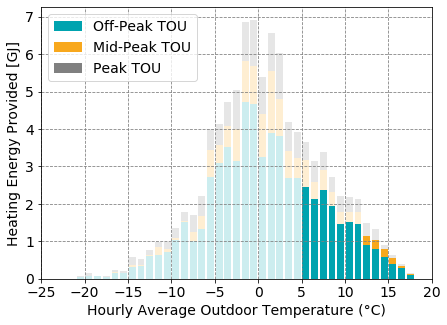

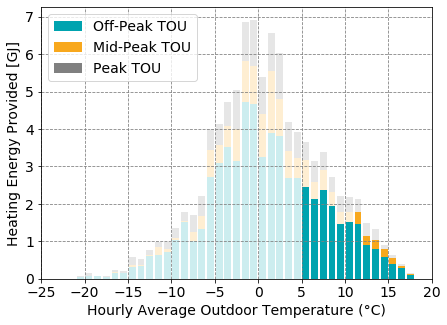

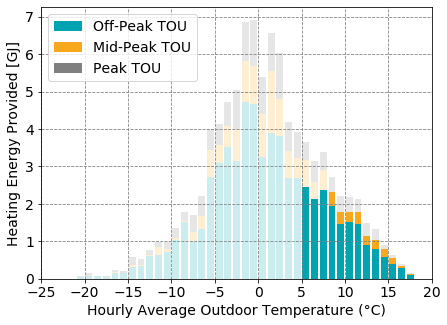

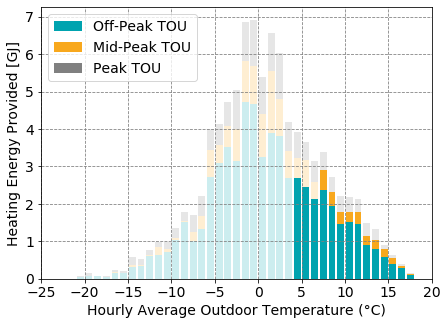

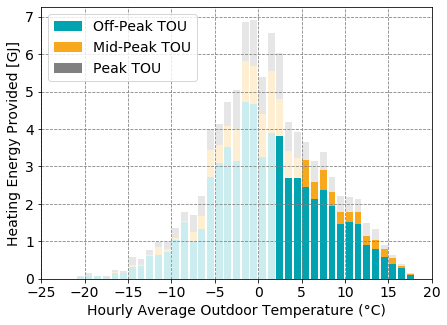

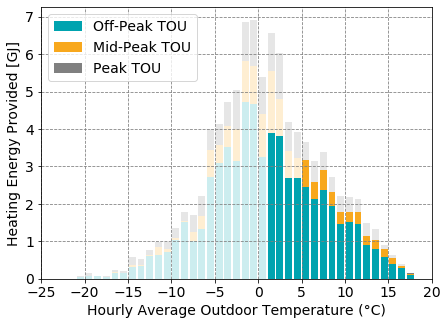

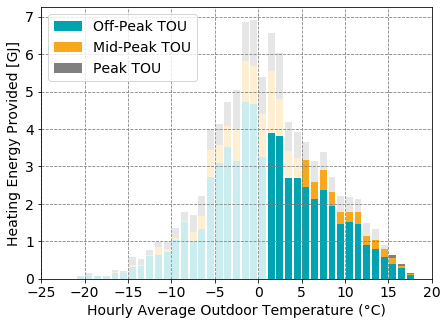

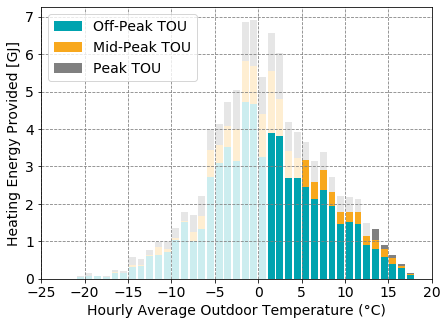

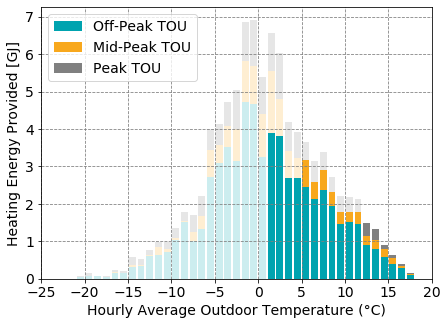

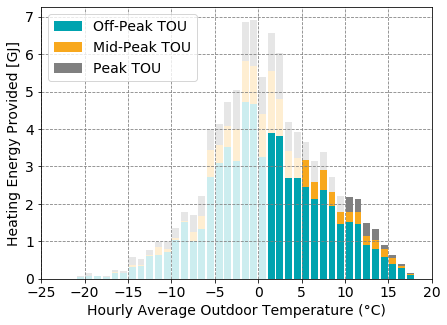

In [155]:
# Define gas rates from 2021 to 2030
natural_gas_rate_2021_2030 = nat_gas_rate_df['Estimated Rate ($/m3)'].to_list()
print(natural_gas_rate_2021_2030)

# Determine annual escalation multiplier for 2021 electricity rates to determine cost in future years
year = [2021,2022,2023,2024,2025,2026,2027,2028,2029,2030]
year_from_2021 = [0,1,2,3,4,5,6,7,8,9]
escalation_multiplier = []
for yr in year_from_2021:
    escalation_multiplier.append((1.02)**yr)

# Define annual electricity rates from 2021 to 2030
elec_rate_off_2021_2030 = []
elec_rate_mid_2021_2030 = []
elec_rate_peak_2021_2030 = []

for mult in escalation_multiplier:
    elec_rate_off_2021_2030.append(0.0995*mult)
    elec_rate_mid_2021_2030.append(0.136*mult)
    elec_rate_peak_2021_2030.append(0.185*mult)

# Calculate annual savings when operating to minimize costs
cost_savings_min_cost = []
carb_savings_min_cost = []

for gas_rate,off_rate,mid_rate,peak_rate in zip(natural_gas_rate_2021_2030,
                                                elec_rate_off_2021_2030,
                                                elec_rate_mid_2021_2030,
                                                elec_rate_peak_2021_2030):
    result = dual_fuel_analyze(hp_size=2, 
                               control='min_cost',
                               print_results='n',
                               plots='y',
                               COP_derate=0.30,
                               gas_cost_m3_func = gas_rate, 
                               elec_cost_off_func = off_rate, 
                               elec_cost_mid_func = mid_rate, 
                               elec_cost_peak_func = peak_rate)
    carb_savings_min_cost.append(result['quick_summary']['tot_carb_savings_percent'][0])
    cost_savings_min_cost.append(result['quick_summary']['tot_cost_savings'][0])
    
print(cost_savings_min_cost)
print(carb_savings_min_cost)
print(sum(cost_savings_min_cost))


[-60, -46, -18, 9, 34, 61, 87, 113, 138, 163]
[39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0]
481


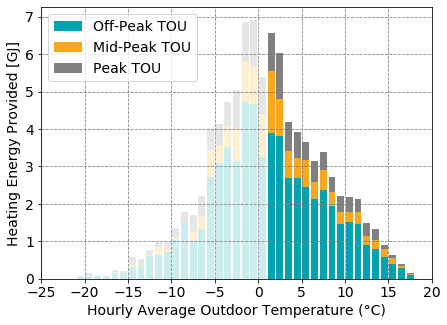

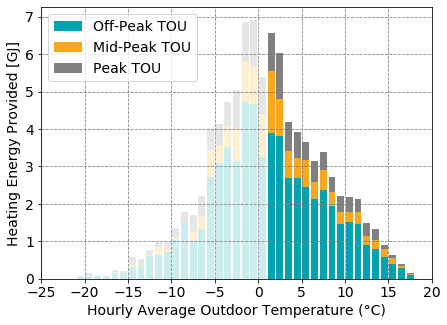

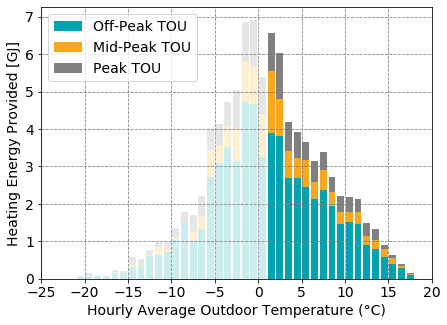

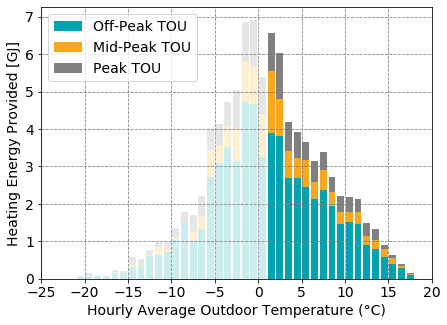

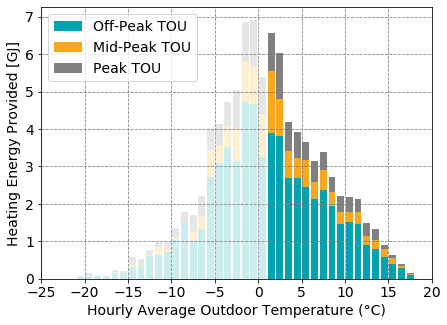

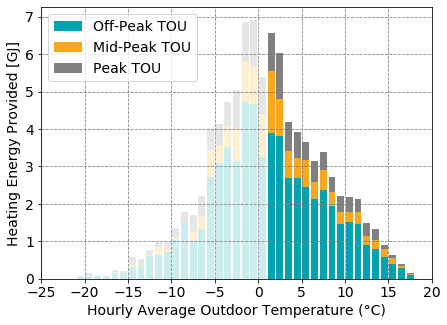

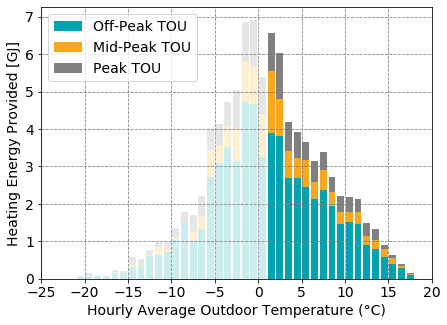

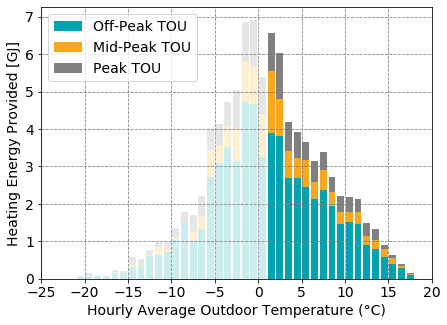

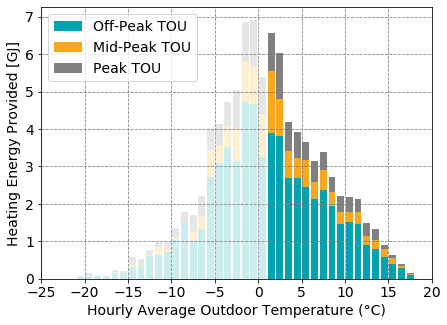

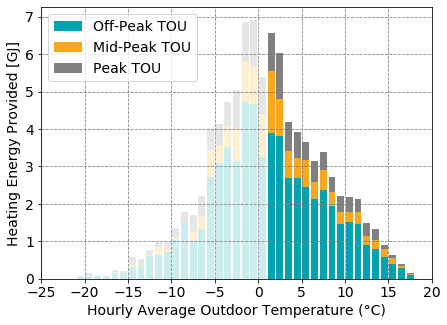

In [156]:
# Calculate annual savings when operating to minimize carbon
cost_savings_min_carb = []
carb_savings_min_carb = []

for gas_rate,off_rate,mid_rate,peak_rate in zip(natural_gas_rate_2021_2030,
                                                elec_rate_off_2021_2030,
                                                elec_rate_mid_2021_2030,
                                                elec_rate_peak_2021_2030):
    result = dual_fuel_analyze(hp_size=2, 
                               control='max_carbon',
                               print_results='n',
                               plots='y',
                               COP_derate=0.30,
                               gas_cost_m3_func = gas_rate, 
                               elec_cost_off_func = off_rate, 
                               elec_cost_mid_func = mid_rate, 
                               elec_cost_peak_func = peak_rate)
    carb_savings_min_carb.append(result['quick_summary']['tot_carb_savings_percent'][0])
    cost_savings_min_carb.append(result['quick_summary']['tot_cost_savings'][0])
    
print(cost_savings_min_carb)
print(carb_savings_min_carb)
print(sum(cost_savings_min_carb))

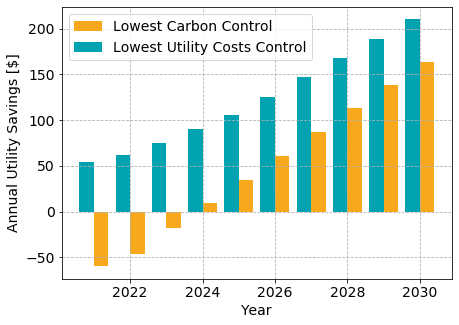

In [160]:
plt.figure(figsize=(7,5))
plt.bar(year,cost_savings_min_carb,align = 'edge', width = 0.4, color = step_gold, label = 'Lowest Carbon Control')
plt.bar(year,cost_savings_min_cost,align = 'edge', width = -0.4, color = step_blue, label = 'Lowest Utility Costs Control')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Annual Utility Savings [$]', fontsize = 14)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize = 14)
plt.grid(ls='--')
plt.savefig('Annual_Savings.png',dpi=1000)